# Preprocessing

In this notebook we document a few preprocessing steps which are not covered by the main preprocessing notebooks in `experiments/v/`. These steps include dimensionality reduction and feature engineering for models which are not designed to handle high-dimensional data (e.g. ARIMAX, HARX, etc.), more specifically:

- Compute trade volume in hourly windows,
- Computing mean value of ob features in hourly windows,
- Computing trend of ob features over time in hourly windows,
- Dimensionality reduction via PCA. 

Computed volume variable is added as a feature to `data_df.csv`, but mean, trend and PCs are not saved as a result of this notebook's computations. 

Mean and trend can be computed in a few ways, so we will test them in the model development notebooks. Retraining dates are not fixed, so we leave the (optional) computation of PCs to be done directly inside each of the models which would benefit from dimensionality reduction.

At the end of notebook we compute a template file to be populated when testing different models. 

In [49]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

sns.set(style="whitegrid")

import os
import sys
from pathlib import Path
from zipfile import ZipFile

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths

In [51]:
data_path = PROJ_ROOT / "data"
raw_data_path = data_path / "raw"

# Compute `volume`

In [52]:
csv_files = list(raw_data_path.glob("bitstamp_trx*.zip"))

In [53]:
dataframes = []

for csv_file in tqdm(csv_files, desc="Processing CSV files"):
    # load and format
    trx_sample = pd.read_csv(csv_file)

    # fix column names by removing spaces and quotes
    trx_sample.columns = [s.replace(" ", "").replace("'", "") for s in trx_sample.columns]

    # 'datetime' columns to datetime type
    # trx_sample["datetime"] = pd.to_datetime(trx_sample["datetime"])

    dataframes.append(trx_sample)

df = pd.concat(dataframes, ignore_index=True)
df["datetime"] = pd.to_datetime(df["datetime"])
# re,move timezone information if exists
df["datetime"] = df["datetime"].dt.tz_localize(None)
df = df.set_index("datetime")
df.sort_index()

Processing CSV files:   0%|          | 0/122 [00:00<?, ?it/s]

Processing CSV files: 100%|██████████| 122/122 [00:06<00:00, 17.89it/s]


timestamp    price         cost        id  \
datetime                                                             
2018-05-31 21:00:13  1527800413000  7538.34    75.383400  67405327   
2018-05-31 21:00:18  1527800418000  7533.92    35.761333  67405331   
2018-05-31 21:00:18  1527800418000  7535.44  2995.337400  67405330   
2018-05-31 21:00:18  1527800418000  7536.00     7.536000  67405329   
2018-05-31 21:00:18  1527800418000  7537.49   753.749000  67405328   
...                            ...      ...          ...       ...   
2018-09-30 21:59:37  1538344777000  6555.78   280.549950  75177318   
2018-09-30 21:59:37  1538344777000  6555.77  1216.049379  75177317   
2018-09-30 21:59:37  1538344777000  6555.76  1497.396225  75177316   
2018-09-30 21:59:37  1538344777000  6555.75  1349.606357  75177315   
2018-09-30 21:59:37  1538344777000  6555.74  1106.925030  75177314   

                                      fee            fee1  order    symbol  \
datetime                                                                     
2018-05-31 21:00:13   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-05-31 21:00:18   {'currency': u'USD'   'cost': None}   None   BTC/USD   
...                                   ...             ...    ...       ...   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   
2018-09-30 21:59:37   {'currency': u'USD'   'cost': None}   None   BTC/USD   

                       amount   type   side  
datetime                                     
2018-05-31 21:00:13  0.010000   None   sell  
2018-05-31 21:00:18  0.004747   None   sell  
2018-05-31 21:00:18  0.397500   None   sell  
2018-05-31 21:00:18  0.001000   None   sell  
2018-05-31 21:00:18  0.100000   None   sell  
...                       ...    ...    ...  
2018-09-30 21:59:37  0.042794   None    buy  
2018-09-30 21:59:37  0.185493   None    buy  
2018-09-30 21:59:37  0.228409   None    buy  
2018-09-30 21:59:37  0.205866   None    buy  
2018-09-30 21:59:37  0.168848   None    buy  

[2795142 rows x 11 columns]

In [54]:
volume = df.amount.resample("1h", closed="left", label="right").sum()
volume


datetime
2018-05-31 22:00:00    220.366844
2018-05-31 23:00:00    705.114174
2018-06-01 00:00:00    215.164963
2018-06-01 01:00:00    297.304541
2018-06-01 02:00:00    112.115274
                          ...    
2018-09-30 18:00:00     26.923696
2018-09-30 19:00:00     49.165087
2018-09-30 20:00:00     96.964626
2018-09-30 21:00:00    290.726892
2018-09-30 22:00:00    108.867295
Freq: h, Name: amount, Length: 2929, dtype: float64

In [55]:
data_df = pd.read_csv(data_path / "btc" / "data_df.csv")
data_df["datetime"] = pd.to_datetime(data_df["datetime"])
data_df = data_df.set_index("datetime")
data_df.sort_index(inplace=True)
data_df = data_df.merge(volume.rename("volume"), left_index=True, right_index=True, how="left")
data_df = data_df.sort_index()

In [56]:
data_df

vol       ret   ret_t-1   ret_t-2   ret_t-3  \
datetime                                                                
2018-06-04 23:00:00  0.000143 -0.002229 -0.000807 -0.001664 -0.002068   
2018-06-05 00:00:00  0.000115  0.001552 -0.000217 -0.002412 -0.000731   
2018-06-05 01:00:00  0.000090 -0.001719  0.001004  0.000560  0.000503   
2018-06-05 02:00:00  0.000502 -0.010899  0.000669  0.000013 -0.000724   
2018-06-05 03:00:00  0.000146  0.000408  0.000473 -0.003603 -0.000386   
...                       ...       ...       ...       ...       ...   
2018-09-30 17:00:00  0.000025 -0.000451 -0.000860  0.002857  0.000204   
2018-09-30 18:00:00  0.000014  0.000298  0.000607 -0.000619 -0.000017   
2018-09-30 19:00:00  0.000024 -0.002138 -0.000023 -0.000018  0.001304   
2018-09-30 20:00:00  0.000089 -0.003682 -0.000012  0.000760 -0.000497   
2018-09-30 21:00:00  0.000034  0.000611 -0.003663 -0.000011  0.001097   

                      ret_t-4   ret_t-5   ret_t-6   ret_t-7   ret_t-8  ...  \
datetime                                                               ...   
2018-06-04 23:00:00  0.001077 -0.002260  0.000301  0.000990  0.000041  ...   
2018-06-05 00:00:00 -0.000816  0.000611  0.000842 -0.000742  0.001837  ...   
2018-06-05 01:00:00 -0.000766 -0.000041 -0.000289 -0.000918  0.000120  ...   
2018-06-05 02:00:00  0.000081 -0.001212  0.001144 -0.000175 -0.000356  ...   
2018-06-05 03:00:00 -0.004847 -0.001068  0.000396  0.001105  0.000261  ...   
...                       ...       ...       ...       ...       ...  ...   
2018-09-30 17:00:00 -0.000439  0.000296  0.000723 -0.000709  0.000164  ...   
2018-09-30 18:00:00 -0.000020 -0.000150 -0.000742 -0.000193  0.000521  ...   
2018-09-30 19:00:00  0.000129  0.000396 -0.000298 -0.000406  0.000384  ...   
2018-09-30 20:00:00 -0.000854 -0.000152  0.000149 -0.002735  0.000052  ...   
2018-09-30 21:00:00 -0.003005  0.000823 -0.005300  0.004849  0.002053  ...   

                     ask_depth_t-120  bid_depth_t-120  depth_diff_t-120  \
datetime                                                                  
2018-06-04 23:00:00           4000.0           2809.0            1191.0   
2018-06-05 00:00:00           4000.0           2802.0            1198.0   
2018-06-05 01:00:00           4000.0           2817.0            1183.0   
2018-06-05 02:00:00           4000.0           2813.0            1187.0   
2018-06-05 03:00:00           4000.0           2772.0            1228.0   
...                              ...              ...               ...   
2018-09-30 17:00:00           4000.0           2841.0            1159.0   
2018-09-30 18:00:00           4000.0           2840.0            1160.0   
2018-09-30 19:00:00           4000.0           2841.0            1159.0   
2018-09-30 20:00:00           4000.0           2845.0            1155.0   
2018-09-30 21:00:00           4000.0           2839.0            1161.0   

                     ask_volume_t-120  bid_volume_t-120  volume_diff_t-120  \
datetime                                                                     
2018-06-04 23:00:00       2341.940396      12782.456607      -10440.516210   
2018-06-05 00:00:00       2362.768003      12699.117466      -10336.349463   
2018-06-05 01:00:00       2349.182465      12790.666762      -10441.484297   
2018-06-05 02:00:00       2356.082089      12731.928549      -10375.846459   
2018-06-05 03:00:00       2329.697927      12634.167822      -10304.469895   
...                               ...               ...                ...   
2018-09-30 17:00:00       2627.367204      11909.731066       -9282.363863   
2018-09-30 18:00:00       2614.198169      11899.085884       -9284.887715   
2018-09-30 19:00:00       2597.208539      11936.342886       -9339.134347   
2018-09-30 20:00:00       2607.346074      11983.235011       -9375.888938   
2018-09-30 21:00:00       2643.073340      11848.354147       -9205.280807   

                     weighted_spread_t-120  ask_slope_t-120  bid_slope

In [57]:
data_df.to_csv(data_path / "btc" / "data_df_with_volume.csv")

# Dimensionality Reduction and Feature Engineering 

Here we document the preprocessing steps used inside each of the simple multivariate models, such as ARIMX, GARCHX, HARX, etc, which are models linear in OB features. Unlike neural networks, these models do not have ability to perform automatic feature engineering. 


## PCA for raw OB features

In [58]:
feature_names = [
    "bid_volume",
    "ask_volume",
    "bid_depth",
    #"ask_depth",
    #"depth_diff",
    "spread",
    "volume_diff",
    "bid_slope",
    "ask_slope",
    "weighted_spread",
]

In [59]:
first_test_time = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")

In [60]:
vis_data = (
    pl.read_csv(data_path / "btc" / "data_df.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
)
vis_data

shape: (2_579, 1_215)
┌───────────┬──────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ datetime  ┆ vol      ┆ ret       ┆ ret_t-1   ┆ … ┆ volume_di ┆ weighted_ ┆ ask_slope ┆ bid_slope │
│ ---       ┆ ---      ┆ ---       ┆ ---       ┆   ┆ ff_t-120  ┆ spread_t- ┆ _t-120    ┆ _t-120    │
│ datetime[ ┆ f64      ┆ f64       ┆ f64       ┆   ┆ ---       ┆ 120       ┆ ---       ┆ ---       │
│ μs]       ┆          ┆           ┆           ┆   ┆ f64       ┆ ---       ┆ f64       ┆ f64       │
│           ┆          ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆           │
╞═══════════╪══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 2018-06-0 ┆ 0.000143 ┆ -0.002229 ┆ -0.000807 ┆ … ┆ -10440.51 ┆ 1036.7256 ┆ 7548.68   ┆ 6997.83   │
│ 4         ┆          ┆           ┆           ┆   ┆ 621       ┆ 48        ┆           ┆           │
│ 23:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.000115 ┆ 0.001552  ┆ -0.000217 ┆ … ┆ -10336.34 ┆ 1031.8000 ┆ 7539.55   ┆ 6937.0    │
│ 5         ┆          ┆           ┆           ┆   ┆ 9463      ┆ 62        ┆           ┆           │
│ 00:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.00009  ┆ -0.001719 ┆ 0.001004  ┆ … ┆ -10441.48 ┆ 1055.5384 ┆ 7531.36   ┆ 6981.42   │
│ 5         ┆          ┆           ┆           ┆   ┆ 4297      ┆ 87        ┆           ┆           │
│ 01:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.000502 ┆ -0.010899 ┆ 0.000669  ┆ … ┆ -10375.84 ┆ 1043.1412 ┆ 7520.68   ┆ 6964.01   │
│ 5         ┆          ┆           ┆           ┆   ┆ 6459      ┆ 15        ┆           ┆           │
│ 02:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-06-0 ┆ 0.000146 ┆ 0.000408  ┆ 0.000473  ┆ … ┆ -10304.46 ┆ 1032.4915 ┆ 7486.98   ┆ 6860.46   │
│ 5         ┆          ┆           ┆           ┆   ┆ 9895      ┆ 35        ┆           ┆           │
│ 03:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ …         ┆ …        ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 2018-09-3 ┆ 0.000025 ┆ -0.000451 ┆ -0.00086  ┆ … ┆ -9282.363 ┆ 1051.1443 ┆ 6629.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 863       ┆ 53        ┆           ┆           │
│ 17:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000014 ┆ 0.000298  ┆ 0.000607  ┆ … ┆ -9284.887 ┆ 969.48667 ┆ 6631.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 715       ┆ 1         ┆           ┆           │
│ 18:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000024 ┆ -0.002138 ┆ -0.000023 ┆ … ┆ -9339.134 ┆ 1066.5140 ┆ 6628.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 347       ┆ 37        ┆           ┆           │
│ 19:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000089 ┆ -0.003682 ┆ -0.000012 ┆ … ┆ -9375.888 ┆ 1066.8463 ┆ 6618.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 938       ┆ 26        ┆           ┆           │
│ 20:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ 2018-09-3 ┆ 0.000034 ┆ 0.000611  ┆ -0.003663 ┆ … ┆ -9205.280 ┆ 1010.3458 ┆ 6590.0    ┆ 6060.0    │
│ 0         ┆          ┆           ┆           ┆   ┆ 807       ┆ 98        ┆           ┆           │
│ 21:00:00  ┆          ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
└───────────┴──────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [61]:
# select features with prefix in feature_names

ob_features = vis_data.select(
    ["datetime"]
    + [f"{feature}_t-{i}" for feature in feature_names for i in range(1, 121)]
).filter(pl.col("datetime") < first_test_time)
ob_features

shape: (621, 961)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ datetime  ┆ bid_volum ┆ bid_volum ┆ bid_volum ┆ … ┆ weighted_ ┆ weighted_ ┆ weighted_ ┆ weighted │
│ ---       ┆ e_t-1     ┆ e_t-2     ┆ e_t-3     ┆   ┆ spread_t- ┆ spread_t- ┆ spread_t- ┆ _spread_ │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ 117       ┆ 118       ┆ 119       ┆ t-120    │
│ μs]       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2018-06-0 ┆ 12731.737 ┆ 12726.892 ┆ 12726.561 ┆ … ┆ 1039.3473 ┆ 1040.0699 ┆ 1038.6945 ┆ 1036.725 │
│ 4         ┆ 072       ┆ 78        ┆ 46        ┆   ┆ 93        ┆ 2         ┆ 29        ┆ 648      │
│ 23:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-0 ┆ 12783.096 ┆ 12779.534 ┆ 12778.562 ┆ … ┆ 1042.6447 ┆ 1038.3170 ┆ 1042.5156 ┆ 1031.800 │
│ 5         ┆ 196       ┆ 09        ┆ 943       ┆   ┆ 88        ┆ 67        ┆ 84        ┆ 062      │
│ 00:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-0 ┆ 12693.048 ┆ 12638.617 ┆ 12602.707 ┆ … ┆ 1051.1130 ┆ 1043.1278 ┆ 1034.6741 ┆ 1055.538 │
│ 5         ┆ 433       ┆ 613       ┆ 947       ┆   ┆ 45        ┆ 34        ┆ 62        ┆ 487      │
│ 01:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-0 ┆ 12789.693 ┆ 12790.602 ┆ 12789.973 ┆ … ┆ 1032.6605 ┆ 1030.0460 ┆ 1042.4665 ┆ 1043.141 │
│ 5         ┆ 43        ┆ 604       ┆ 813       ┆   ┆ 3         ┆ 79        ┆ 22        ┆ 215      │
│ 02:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-0 ┆ 12729.654 ┆ 12746.461 ┆ 12729.449 ┆ … ┆ 1023.5248 ┆ 1027.5639 ┆ 1028.1252 ┆ 1032.491 │
│ 5         ┆ 832       ┆ 117       ┆ 356       ┆   ┆ 88        ┆ 35        ┆ 59        ┆ 535      │
│ 03:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ …         ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …        │
│ 2018-06-3 ┆ 14855.759 ┆ 14854.847 ┆ 14857.467 ┆ … ┆ 1272.9992 ┆ 1276.7667 ┆ 1278.7382 ┆ 1281.442 │
│ 0         ┆ 626       ┆ 893       ┆ 6         ┆   ┆ 5         ┆ 56        ┆ 41        ┆ 451      │
│ 17:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-3 ┆ 14898.515 ┆ 14898.515 ┆ 14907.030 ┆ … ┆ 1288.9478 ┆ 1284.4117 ┆ 1291.4033 ┆ 1296.733 │
│ 0         ┆ 296       ┆ 296       ┆ 135       ┆   ┆ 04        ┆ 03        ┆ 59        ┆ 618      │
│ 19:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-3 ┆ 15005.503 ┆ 14999.677 ┆ 14995.838 ┆ … ┆ 1281.8576 ┆ 1280.9301 ┆ 1290.0519 ┆ 1284.884 │
│ 0         ┆ 782       ┆ 305       ┆ 279       ┆   ┆ 29        ┆ 89        ┆ 69        ┆ 951      │
│ 20:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-3 ┆ 14986.859 ┆ 14981.517 ┆ 14981.769 ┆ … ┆ 1318.6853 ┆ 1329.5283 ┆ 1327.2704 ┆ 1331.177 │
│ 0         ┆ 656       ┆ 793       ┆ 691       ┆   ┆ 18        ┆ 38        ┆ 94        ┆ 783      │
│ 21:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2018-06-3 ┆ 15033.926 ┆ 15026.891 ┆ 15025.559 ┆ … ┆ 1315.8672 ┆ 1313.1253 ┆ 1313.0287 ┆ 1303.174 │
│ 0         ┆ 74        ┆ 355       ┆ 43        ┆   ┆ 87        ┆ 7         ┆ 17        ┆ 434      │
│ 22:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [62]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
ob_features_scaled = scaler.fit_transform(ob_features.drop("datetime"))
# Perform PCA
pca = PCA(n_components=5)
ob_features_pca = pca.fit_transform(ob_features_scaled)
# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=ob_features_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
pca_df["datetime"] = ob_features["datetime"].to_numpy()
pca_df["datetime"] = pd.to_datetime(pca_df["datetime"])
pca_df = pca_df.sort_values("datetime")

In [63]:
pca_df.set_index("datetime", inplace=True)

<Axes: xlabel='datetime'>

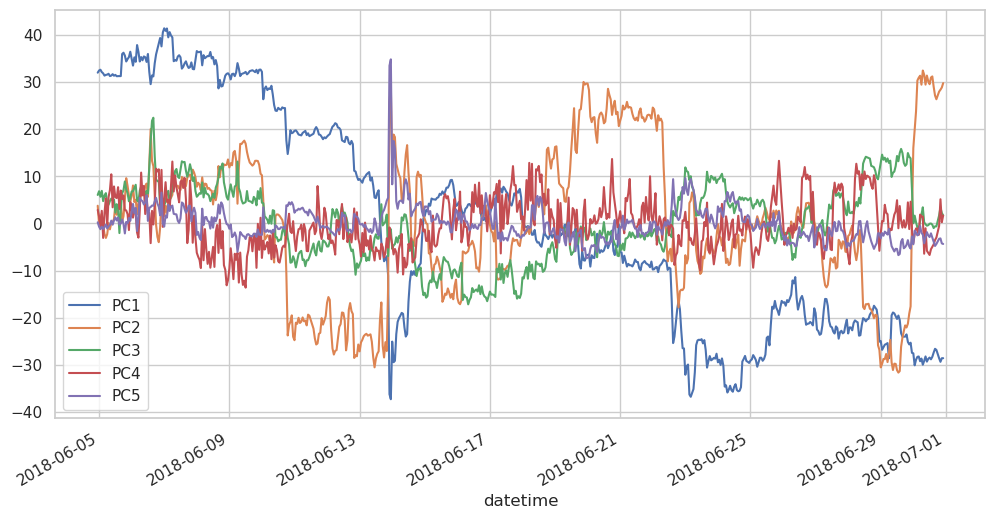

In [64]:
pca_df.plot(figsize=(12, 6))

In [65]:
# explained variance

explained_variance = pca.explained_variance_ratio_.cumsum()
explained_variance

array([0.52829288, 0.77249129, 0.83438432, 0.86407452, 0.87868263])

In [66]:
ob_features_scaled.shape

(621, 960)

In [67]:
# see PCA loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=ob_features.columns[1:], columns=pca_df.columns[:])
#loadings_df = loadings_df.sort_values(by="PC1", ascending=False)

In [68]:
loadings_df

PC1       PC2       PC3       PC4       PC5
bid_volume_t-1        -0.889053  0.332537  0.265755 -0.078613 -0.078767
bid_volume_t-2        -0.889269  0.332514  0.264472 -0.078574 -0.076760
bid_volume_t-3        -0.890536  0.329341  0.265086 -0.079072 -0.074962
bid_volume_t-4        -0.889647  0.331147  0.264807 -0.078568 -0.079175
bid_volume_t-5        -0.890177  0.330048  0.264674 -0.077383 -0.078340
...                         ...       ...       ...       ...       ...
weighted_spread_t-116 -0.647962  0.621582  0.094052  0.008717  0.166729
weighted_spread_t-117 -0.646904  0.609278  0.082494  0.017585  0.245361
weighted_spread_t-118 -0.659265  0.611752  0.095674  0.018878  0.153009
weighted_spread_t-119 -0.649639  0.617786  0.098035  0.005344  0.160015
weighted_spread_t-120 -0.645284  0.620583  0.099181  0.016820  0.168878

[960 rows x 5 columns]

In [69]:
loadings_df.loc[loadings_df.index.str.contains("bid_volume"),:]

PC1       PC2       PC3       PC4       PC5
bid_volume_t-1   -0.889053  0.332537  0.265755 -0.078613 -0.078767
bid_volume_t-2   -0.889269  0.332514  0.264472 -0.078574 -0.076760
bid_volume_t-3   -0.890536  0.329341  0.265086 -0.079072 -0.074962
bid_volume_t-4   -0.889647  0.331147  0.264807 -0.078568 -0.079175
bid_volume_t-5   -0.890177  0.330048  0.264674 -0.077383 -0.078340
...                    ...       ...       ...       ...       ...
bid_volume_t-116 -0.892133  0.327158  0.269815 -0.077226 -0.066654
bid_volume_t-117 -0.891845  0.328606  0.268122 -0.077644 -0.067727
bid_volume_t-118 -0.891578  0.329124  0.269275 -0.078600 -0.064692
bid_volume_t-119 -0.891732  0.329360  0.268384 -0.078063 -0.064035
bid_volume_t-120 -0.891969  0.329317  0.268370 -0.078318 -0.063240

[120 rows x 5 columns]

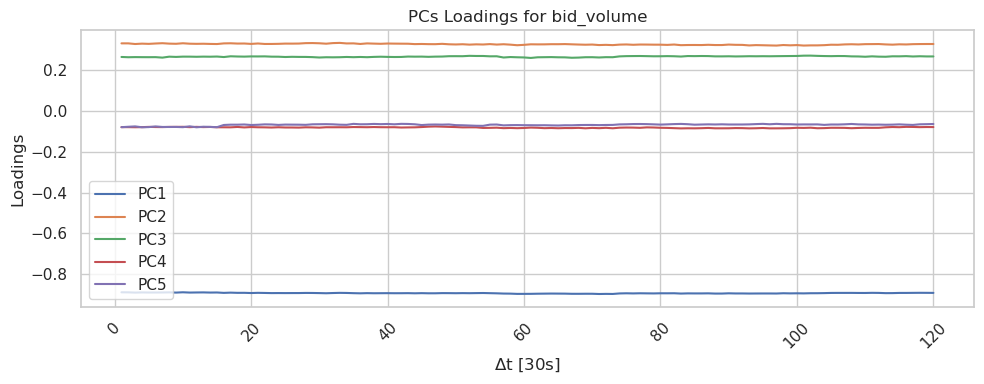

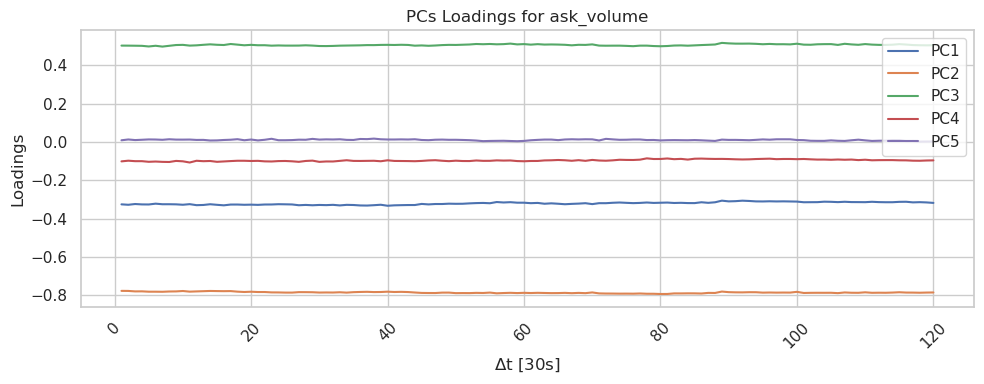

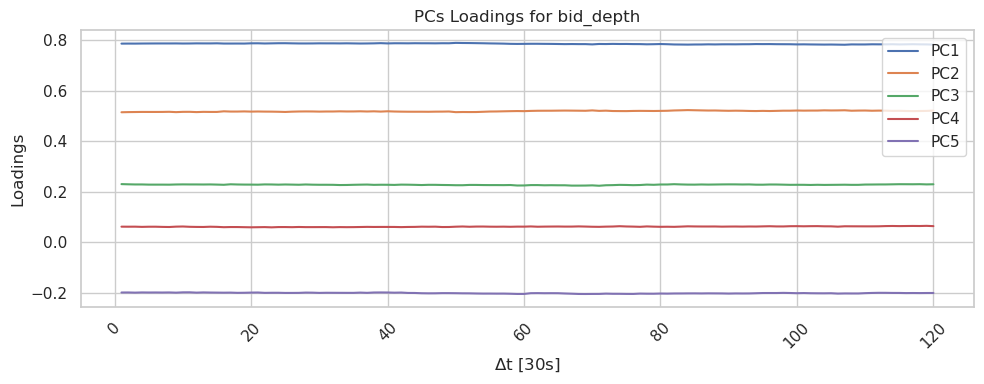

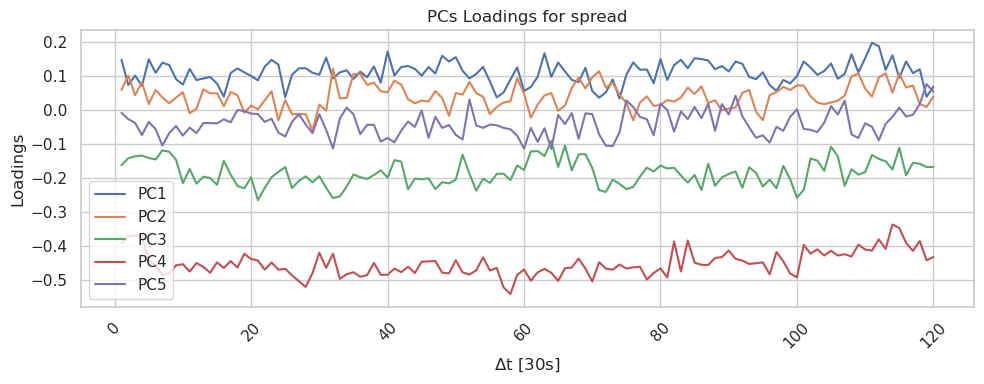

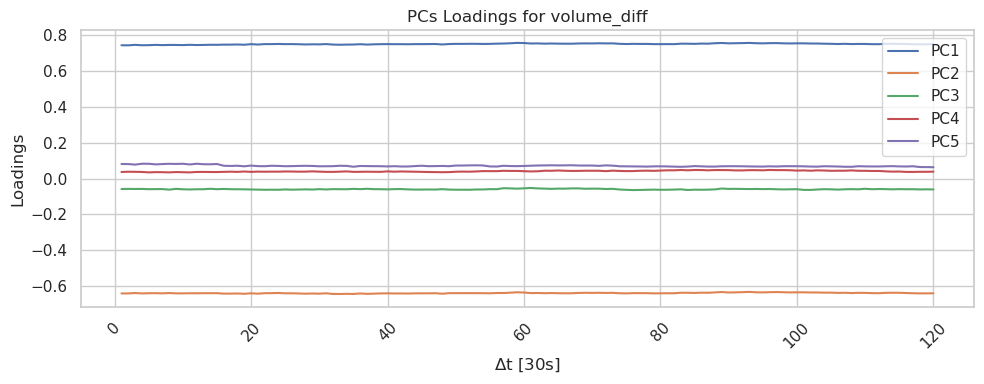

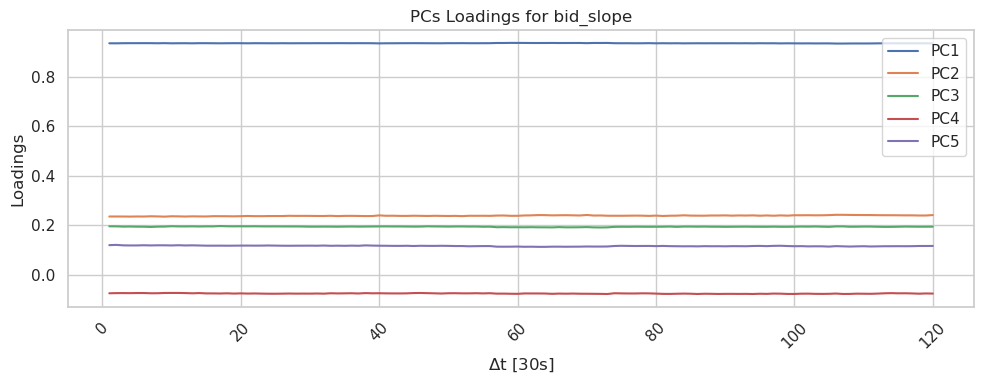

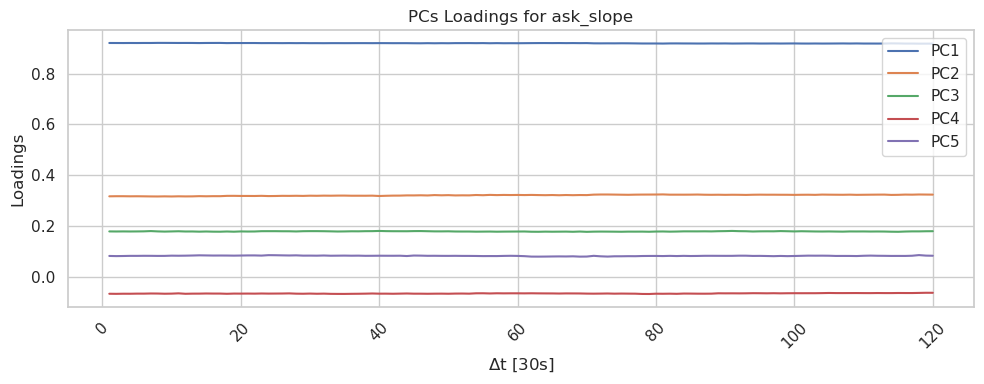

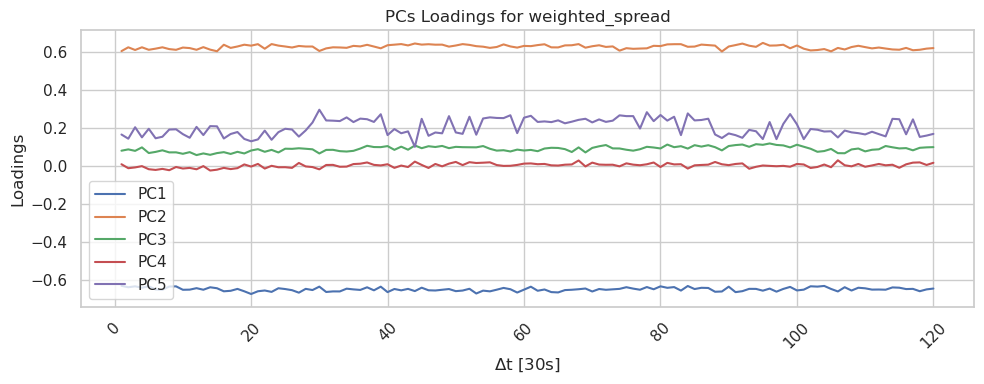

In [70]:
# for each feature in feature_names, slect features from loadings_df which have
# the feature_name as prefix, sort them by sufix and plot loadings
for feature in feature_names:
    feature_loadings_temp = loadings_df.loc[loadings_df.index.str.startswith(feature),:]
    # transform sufix to time variable
    feature_loadings_temp.index = feature_loadings_temp.index.str.replace(f"{feature}_t-", "").astype(int)
    feature_loadings_temp = feature_loadings_temp.sort_index()
    plt.figure(figsize=(10, 4))
    plt.plot(feature_loadings_temp.index, feature_loadings_temp)
    plt.legend(feature_loadings_temp.columns)
    plt.title(f"PCs Loadings for {feature}")
    plt.xlabel(r"$\Delta$t [30s]" )
    plt.ylabel("Loadings")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [71]:
# for each PC, average the loadings over time delta for each feature
mean_loadings = pd.DataFrame(index=feature_names, columns=pca_df.columns[:])
for pc in pca_df.columns:
    for feature in feature_names:
        mean_load = loadings_df.loc[loadings_df.index.str.startswith(feature), pc].values.mean()
        mean_loadings.loc[feature, pc] = mean_load

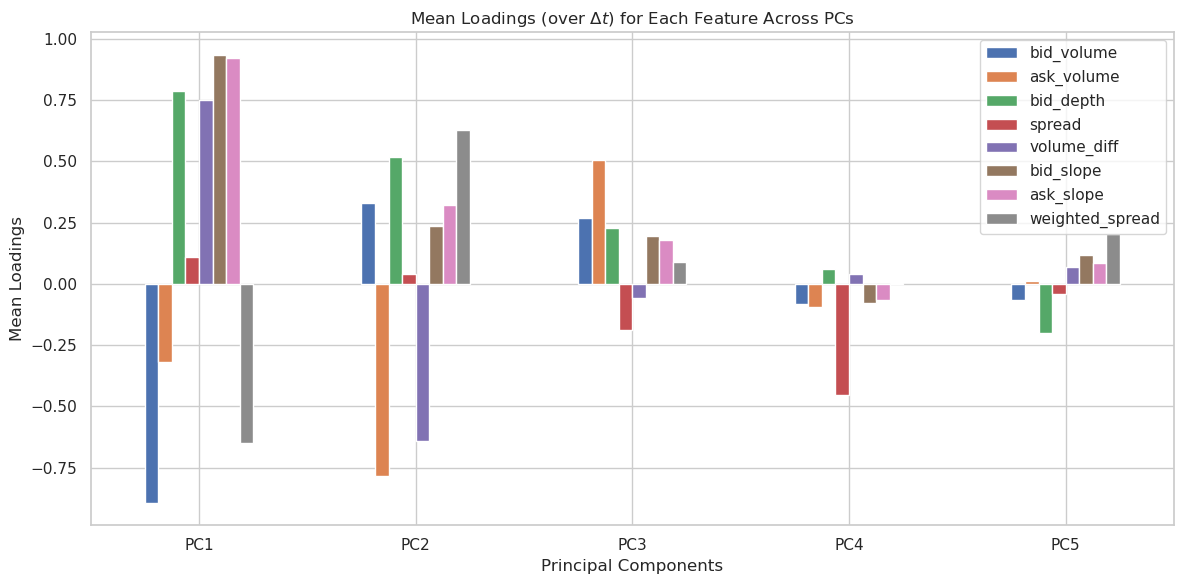

In [72]:
# plot mean loadings
mean_loadings_tr = mean_loadings.T
mean_loadings_tr.plot(kind="bar", figsize=(12, 6))
plt.title(r"Mean Loadings (over $\Delta t$) for Each Feature Across PCs")
plt.xlabel("Principal Components")
plt.ylabel("Mean Loadings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

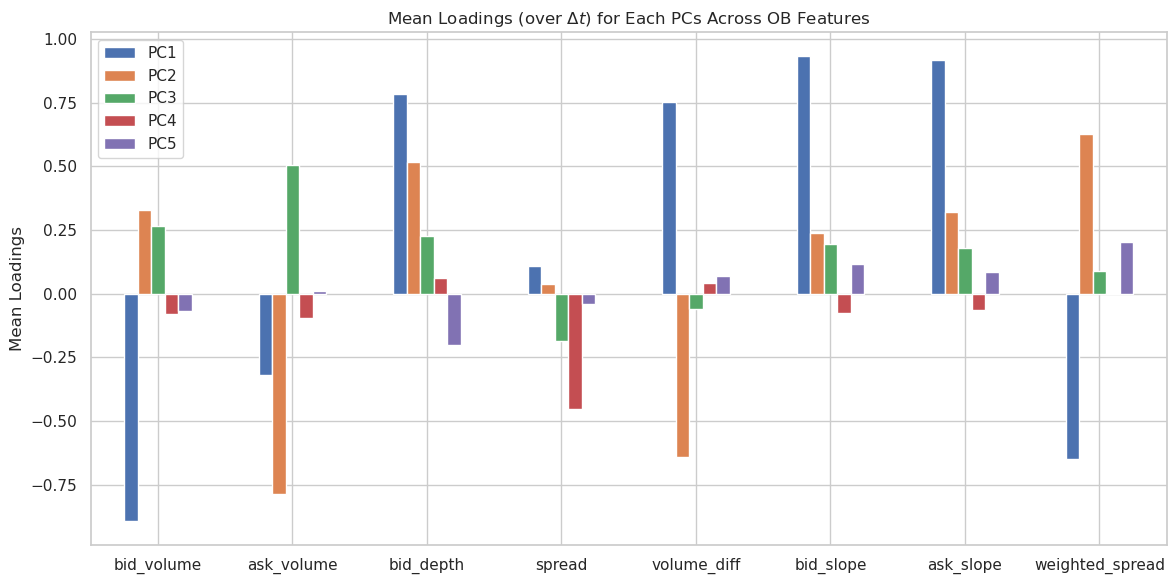

In [73]:
mean_loadings.plot(kind="bar", figsize=(12, 6))
plt.title(r"Mean Loadings (over $\Delta t$) for Each PCs Across OB Features")
#plt.xlabel("Principal Components")
plt.ylabel("Mean Loadings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Conclusions

- Loadings of PCs over same OB features are independent of $\Delta t$, as expected. So each PC is a weighted sum of the same OB features with weights are independent of $\Delta t$. It means we can use 5 PCs instead of level (means over $\Delta t$) of the original 8 OB features.
- Thus PCA effectively reduces the number of OB features from 8 to 5, not from 1190 to 5, to explain $\approx$ 90% of variance.
- PC1, PC2 and PC5 have to obvious interpretation,
- PC3 is some kind of general volume,
- PC4 is close to the spread 

## Mean and trend for OB features

The idea of this subsection is to compute mean of OB features over a given time window, e.g. 1 hour, and use it as a feature in the model. This is very similar to the PCa, as diffferent PCs are weitghted sums of the same OB features, where weights are almost constant over different $\Delta t$.

Another idea is to fit a linear regression of the feature vs time, and use the slope (trend) of the OB feature as a feature. That way we want to extract whether the feature is increasing or decreasing over time, and use it as a feature in the model. 

Turns out the slope is relatively noisy so we will try to compute it as a difference between the mean value of the OB features in the first 30 minutes and the mean value in the last 30 minutes of the given hour. We will scale it by the mean value of the OB feature in the whole hourly window.

In [74]:
LAST_TRAINING_DATE = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")

training_data = (
    pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
).to_pandas().set_index("datetime").loc[:LAST_TRAINING_DATE]

In [75]:
# the same two redundant features are eliminated
columns_list = [
    "spread", 
    # "ask_depth", 
    "bid_depth", 
    # "depth_diff", 
    "ask_volume", 
    "bid_volume", 
    "volume_diff", 
    "weighted_spread", 
    "ask_slope", 
    "bid_slope",
]

In [76]:
for col in columns_list:
    training_data[f'mean_{col}'] = training_data.loc[:, training_data.columns.str.startswith(col)].mean(axis=1)

    training_data[f'trend_{col}'] = training_data.loc[:, training_data.columns.str.startswith(col)].apply(
        lambda x: np.polyfit(range(len(x)), x, 1)[0], axis=1
    )

    columns_to_use = training_data.columns[training_data.columns.str.startswith(col)]
    # sort columns by the time delta, e.g. "bid_volume_t-1", "bid_volume_t-2", ..., "bid_volume_t-60"
    columns_to_use = sorted(columns_to_use, key=lambda x: int(x.split("_t-")[-1]))

    # robust trend = mean of the first 60 values minus the mean of the last 60 values
    training_data[f'robust_trend_{col}'] = (
        (training_data.loc[:, columns_to_use[-60:]].mean(axis=1) - training_data.loc[:, columns_to_use[:60]].mean(axis=1))/ training_data.loc[:, columns_to_use[:]].mean(axis=1)
    )

    # standardze the trend
    training_data[f'trend_{col}'] = (
        training_data[f'trend_{col}'] - training_data[f'trend_{col}'].mean()
    ) / training_data[f'trend_{col}'].std()
    # standardize the robust trend
    training_data[f'robust_trend_{col}'] = (
        training_data[f'robust_trend_{col}'] - training_data[f'robust_trend_{col}'].mean()
    ) / training_data[f'robust_trend_{col}'].std()

In [77]:
training_data = training_data.dropna().loc[:, 
                          ['vol'] +
                          [f'mean_{col}' for col in columns_list] + 
                          [f'trend_{col}' for col in columns_list] +
                          [f'robust_trend_{col}' for col in columns_list]
                          ]

In [78]:
training_data

vol  mean_spread  mean_bid_depth  mean_ask_volume  \
datetime                                                                      
2018-06-04 23:00:00  0.000143     4.617000     2808.416667      2293.170108   
2018-06-05 00:00:00  0.000115     4.955333     2803.741667      2383.019695   
2018-06-05 01:00:00  0.000090     5.568167     2810.800000      2348.723498   
2018-06-05 02:00:00  0.000502     4.659333     2814.191667      2339.586743   
2018-06-05 03:00:00  0.000146     6.203417     2785.916667      2372.844947   
...                       ...          ...             ...              ...   
2018-06-30 17:00:00  0.000154     6.176167     2557.083333      2092.303235   
2018-06-30 19:00:00  0.000089     5.389583     2565.350000      2108.711393   
2018-06-30 20:00:00  0.000202     3.821000     2574.766667      2105.123597   
2018-06-30 21:00:00  0.000126     5.137833     2586.366667      2101.037744   
2018-06-30 22:00:00  0.000144     4.835333     2584.116667      2061.931272   

                     mean_bid_volume  mean_volume_diff  mean_weighted_spread  \
datetime                                                                       
2018-06-04 23:00:00     12745.754470     -10452.584362           1049.120542   
2018-06-05 00:00:00     12703.079253     -10320.059558           1031.974280   
2018-06-05 01:00:00     12712.382418     -10363.658919           1034.160158   
2018-06-05 02:00:00     12749.389193     -10409.802450           1039.381700   
2018-06-05 03:00:00     12694.560994     -10321.716046           1032.704400   
...                              ...               ...                   ...   
2018-06-30 17:00:00     14849.814767     -12757.511532           1283.348564   
2018-06-30 19:00:00     14948.667959     -12839.956566           1302.927669   
2018-06-30 20:00:00     15004.766335     -12899.642738           1301.102242   
2018-06-30 21:00:00     14995.197588     -12894.159844           1299.839156   
2018-06-30 22:00:00     14998.221184     -12936.289912           1298.491609   

                     mean_ask_slope  mean_bid_slope  trend_spread  ...  \
datetime                                                           ...   
2018-06-04 23:00:00     7564.560917     6969.211333      0.646738  ...   
2018-06-05 00:00:00     7531.220000     6940.756083      1.281789  ...   
2018-06-05 01:00:00     7537.406833     6944.465667      1.716463  ...   
2018-06-05 02:00:00     7531.810833     6969.692333     -0.141608  ...   
2018-06-05 03:00:00     7490.462750     6921.164667      0.859693  ...   
...                             ...             ...           ...  ...   
2018-06-30 17:00:00     6407.300417     5766.342083      0.100241  ...   
2018-06-30 19:00:00     6382.392667     5797.928917     -0.224941  ...   
2018-06-30 20:00:00     6375.012750     5791.052917      0.061675  ...   
2018-06-30 21:00:00     6386.450583     5793.017667      2.160934  ...   
2018-06-30 22:00:00     6397.811917     5792.877083      0.050517  ...   

                     trend_ask_slope  trend_bid_slope  robust_trend_spread  \
datetime                                                                     
2018-06-04 23:00:00        -0.454454         0.503884             0.845068   
2018-06-05 00:00:00         0.114989        -0.897284             1.184313   
2018-06-05 01:00:00        -0.432276         1.558462             0.882161   
2018-06-05 02:00:00        -0.568660        -0.177203            -0.150263   
2018-06-05 03:00:00        -0.913328        -1.630942             0.946681   
...                              ...              ...                  ...   
2018-06-30 17:00:00        -0.249633         0.491831             0.455278   
2018-06-30 19:00:00        -0.304230         0.090381            -0.097765   
2018-06-30 20:00:00         0.144084         0.105543             0.991881   
2018-06-30 21:00:00         0.663720         0.315948             1.716649   
2018-06-30 22:00:00        -0.182902        -0.193498     

In [79]:
# plot features one by one
def plot_feature(df, feature, problematic_timestamps=None):
    plt.figure(figsize=(12, 3))
    plt.scatter(df.index, df[feature], label=feature, alpha=1, s=0.3)
    plt.title(f"{feature} over time")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.legend()

    if problematic_timestamps is not None:
        for timestamp in problematic_timestamps:
            plt.axvline(
                x=timestamp, color="r", linestyle="--", label="Problematic Timestamp"
            )
    plt.show()

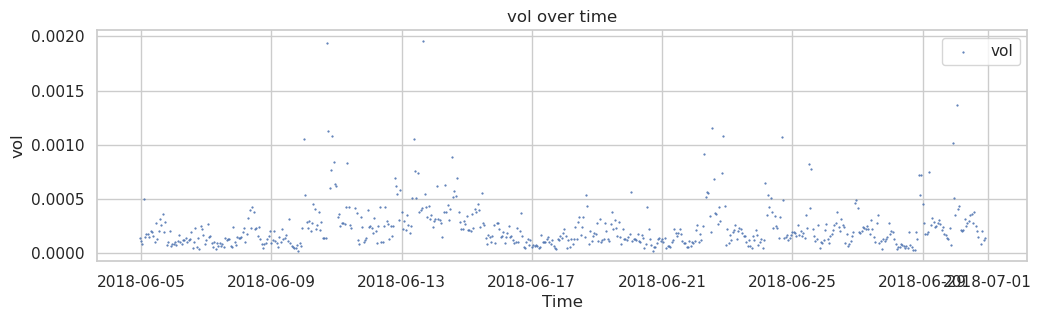

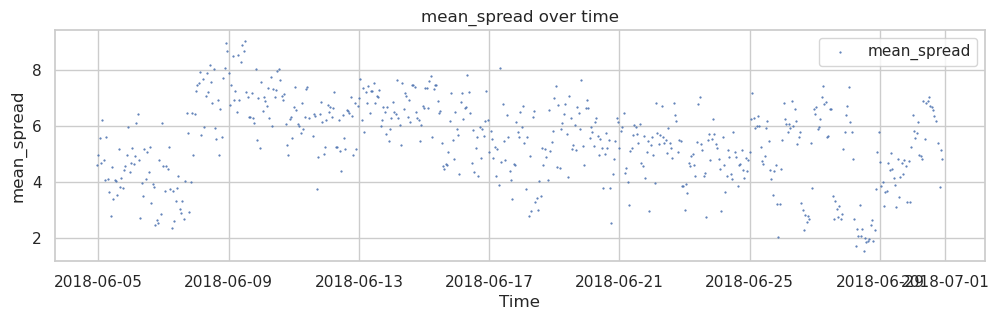

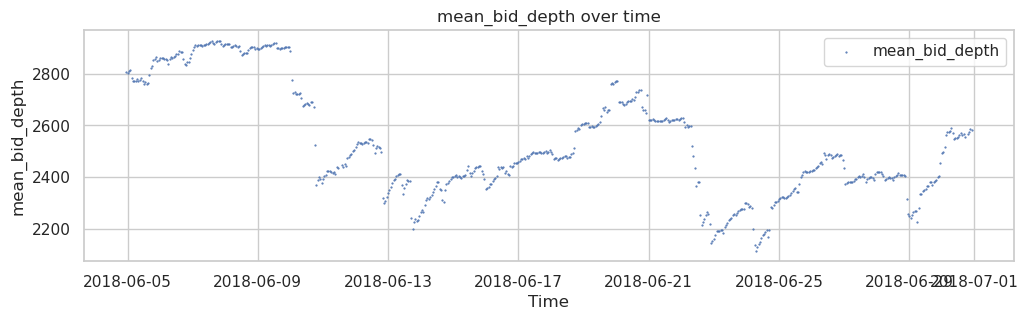

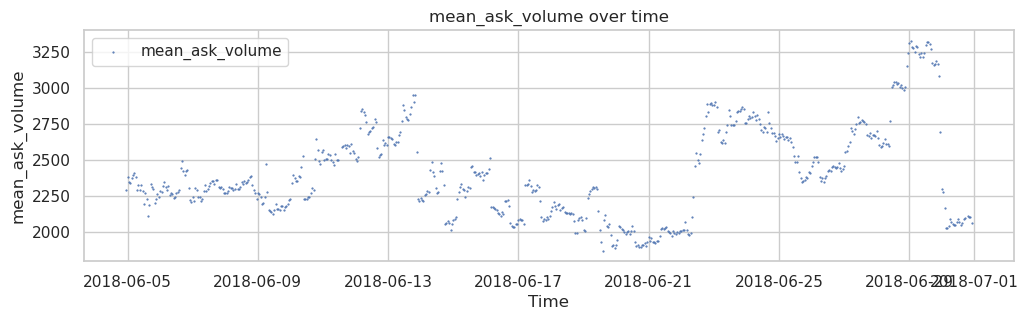

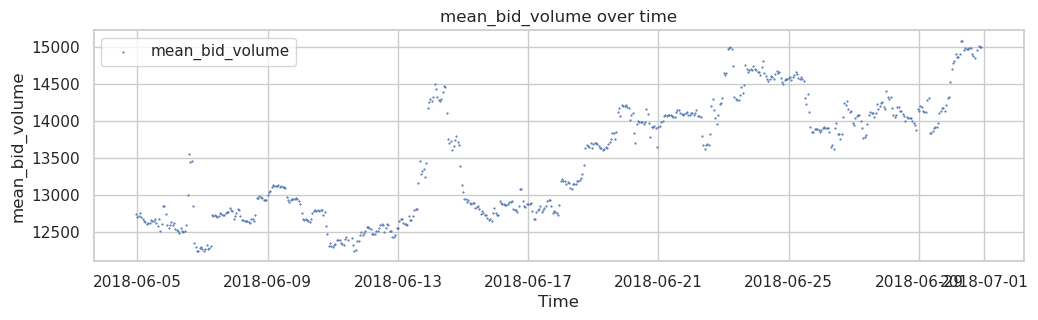

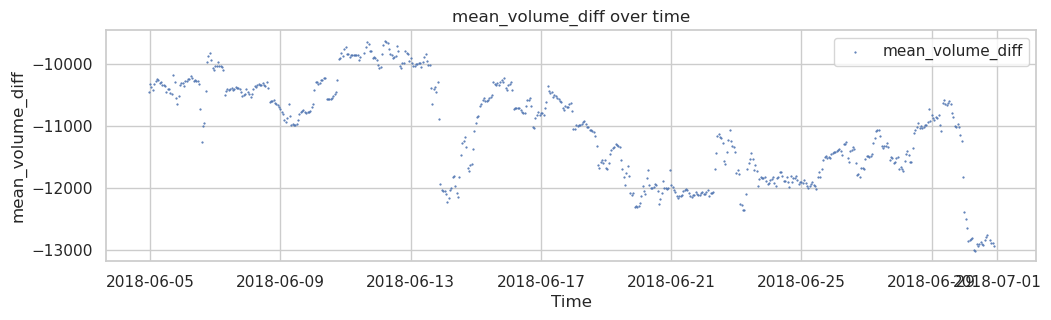

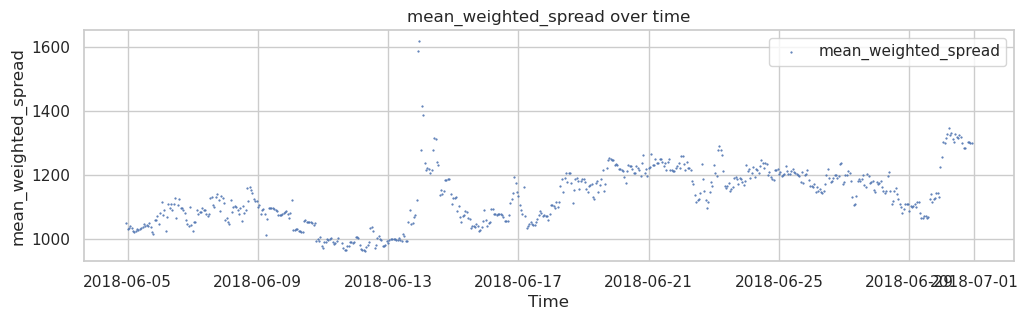

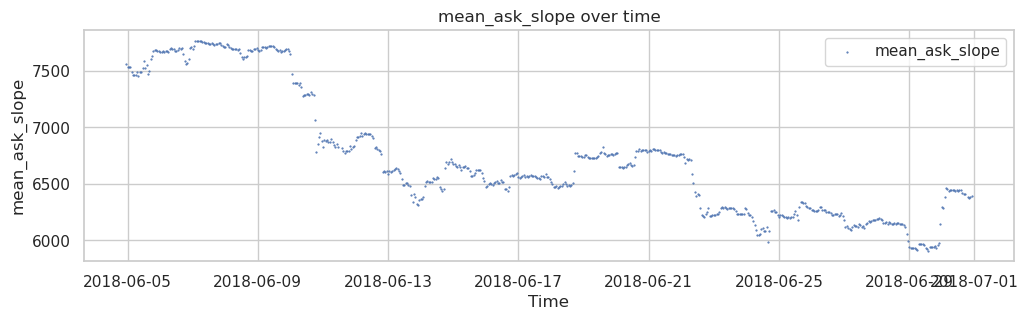

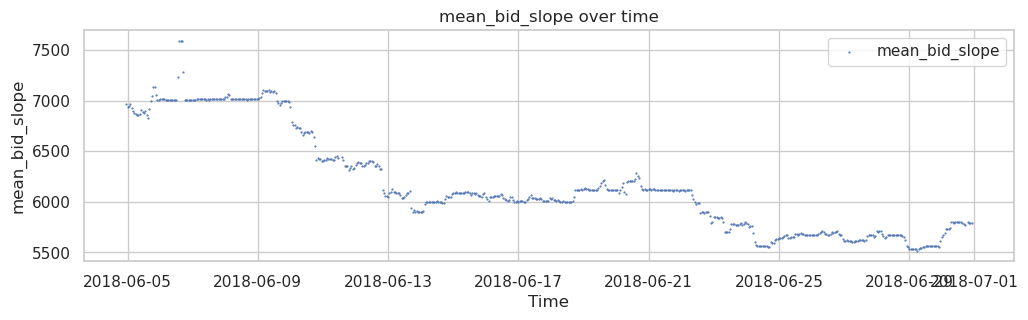

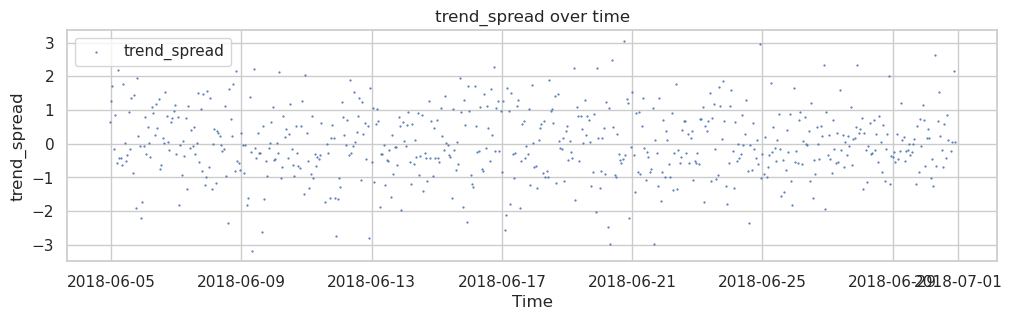

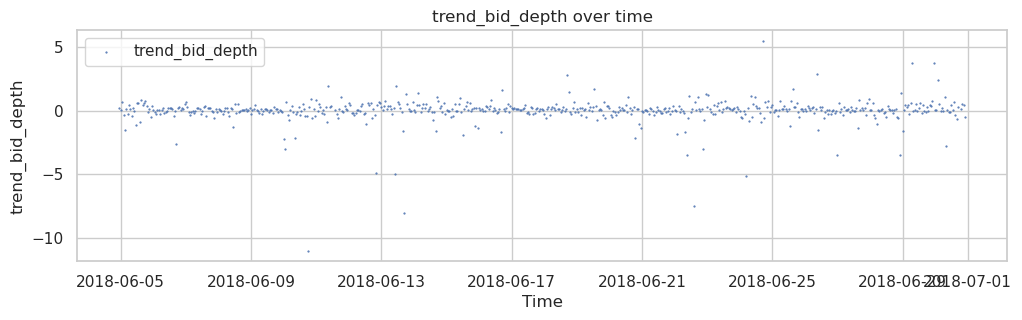

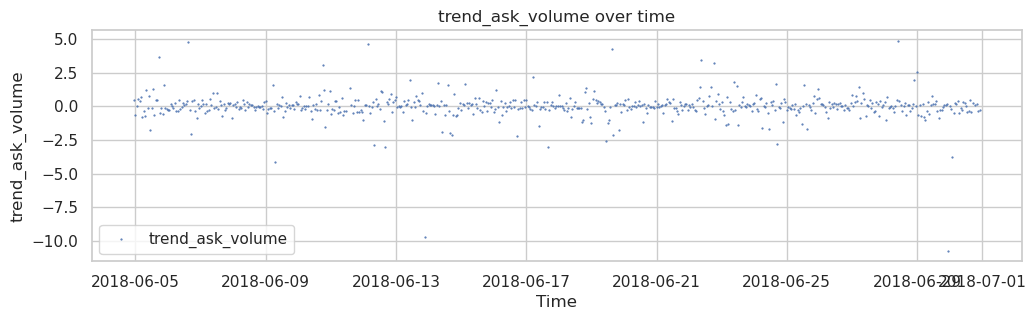

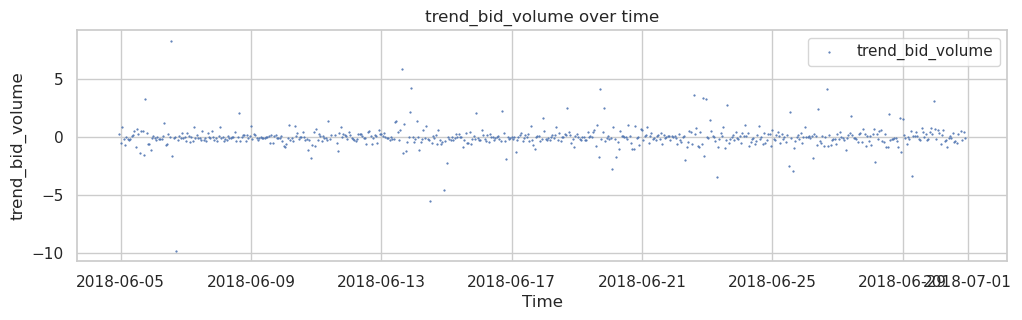

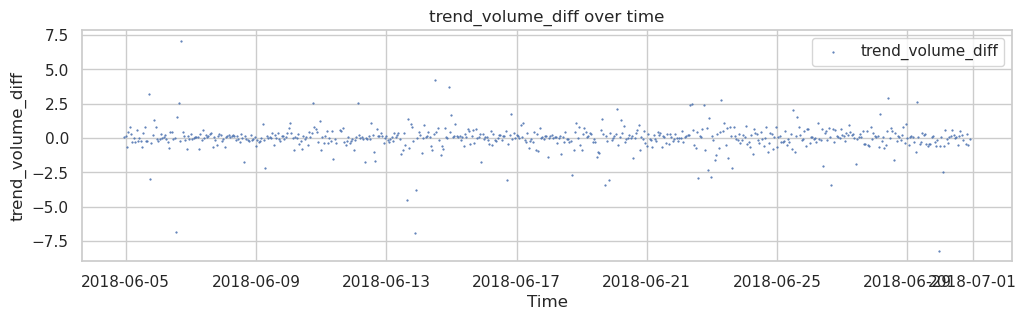

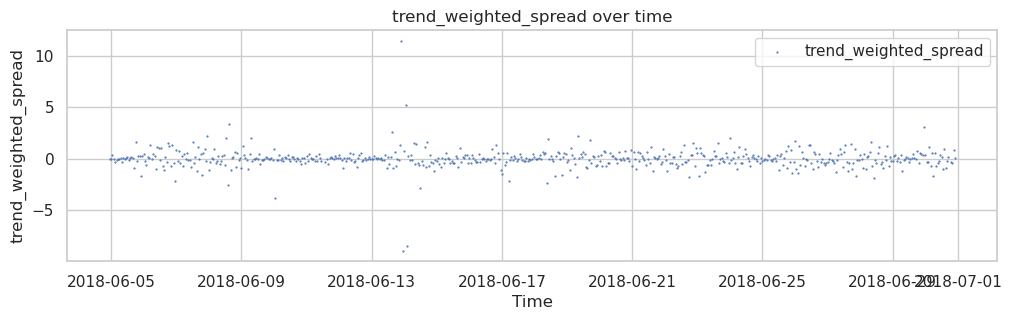

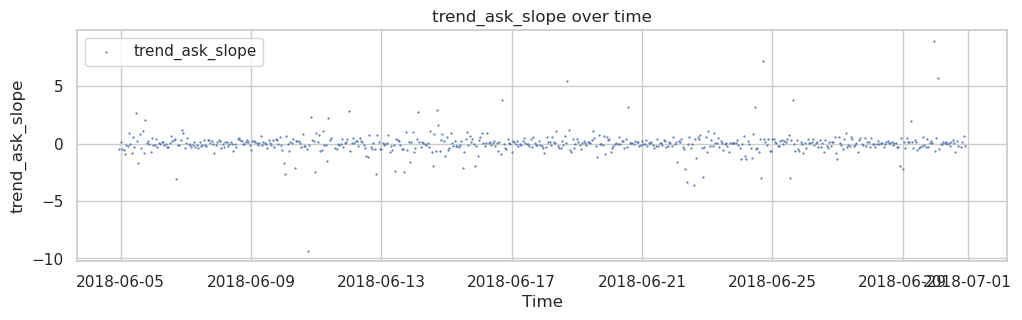

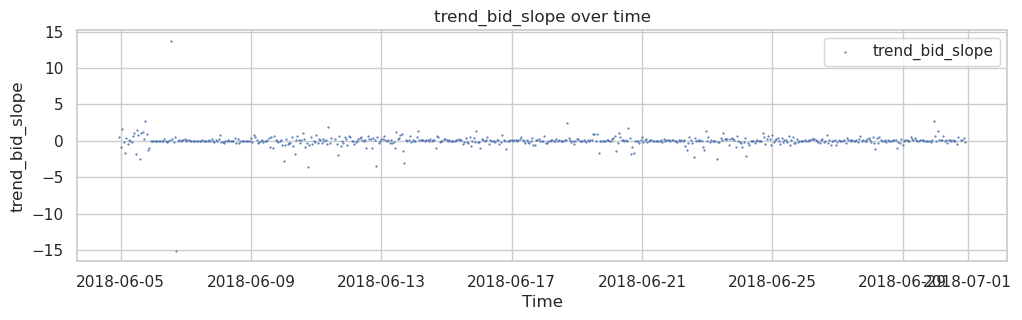

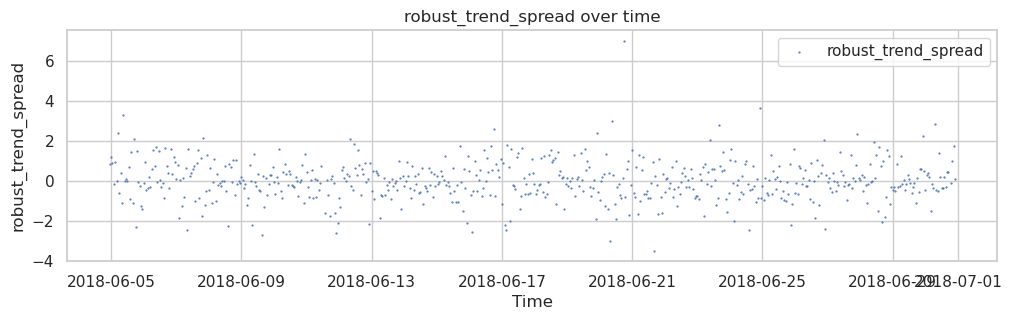

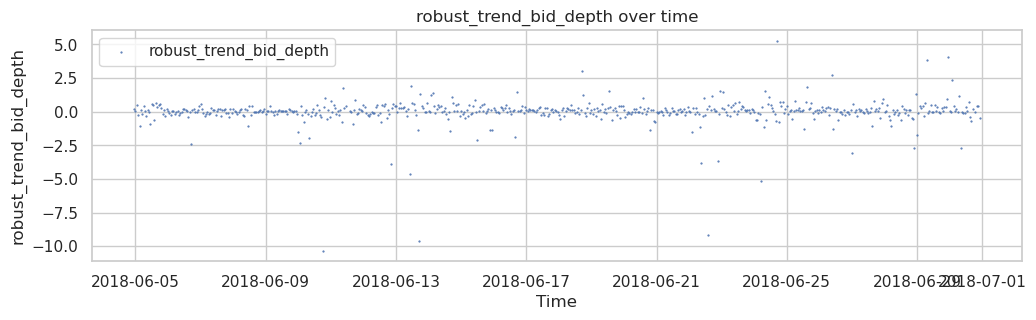

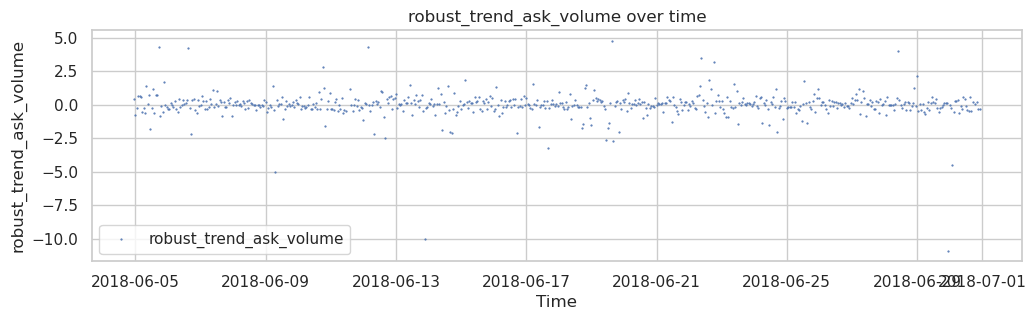

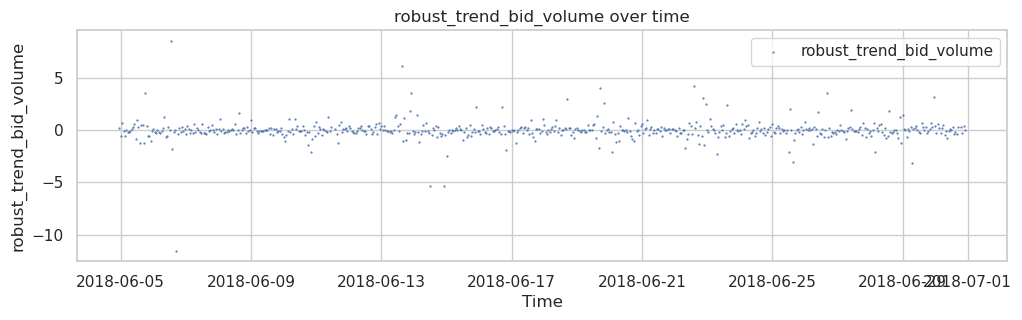

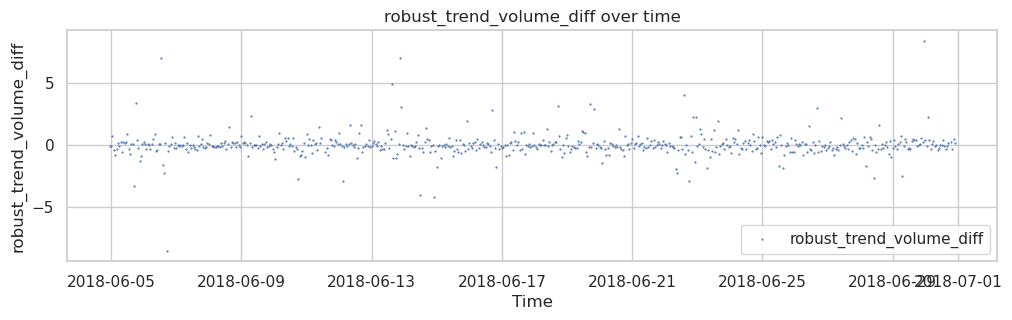

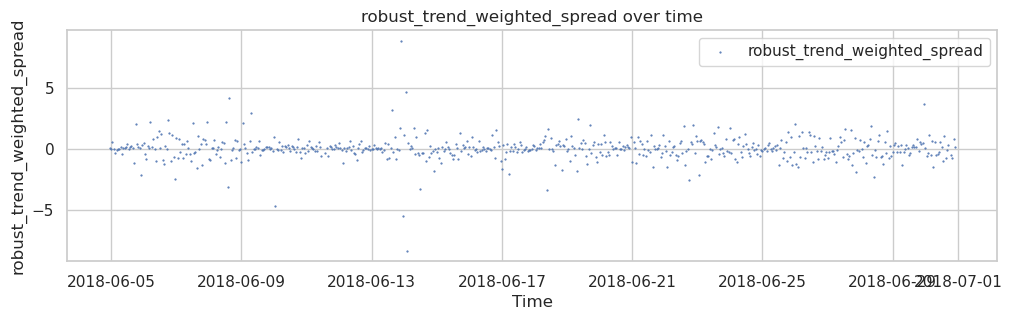

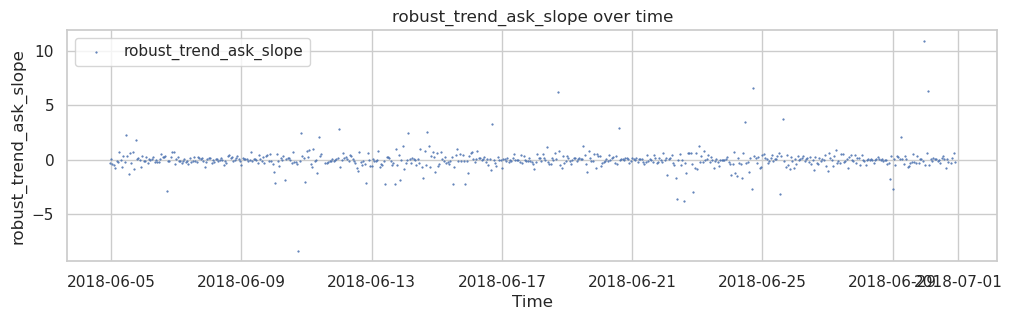

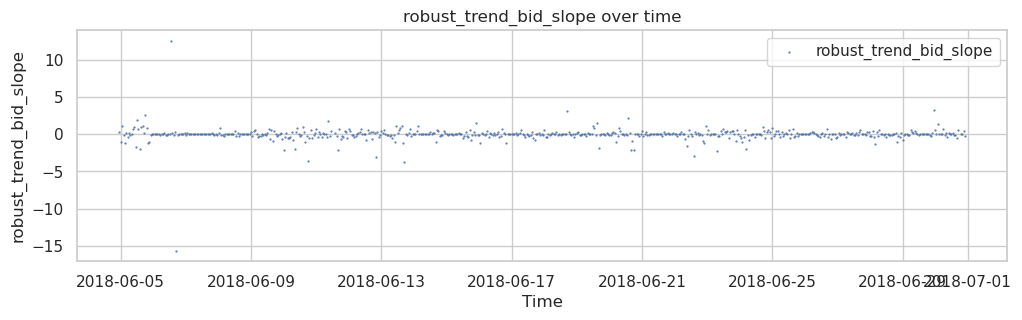

In [80]:
for feature in training_data.columns:
    plot_feature(training_data, feature)

In [81]:
training_data.describe()

vol  mean_spread  mean_bid_depth  mean_ask_volume  \
count  621.000000   621.000000      621.000000       621.000000   
mean     0.000240     5.453953     2530.860427      2407.165559   
std      0.000211     1.438161      214.400727       319.718893   
min      0.000023     1.546917     2113.608333      1866.562313   
25%      0.000116     4.566000     2383.716667      2166.616765   
50%      0.000182     5.588417     2476.475000      2342.686001   
75%      0.000282     6.508500     2684.200000      2626.444721   
max      0.001959     9.037417     2929.025000      3329.605814   

       mean_bid_volume  mean_volume_diff  mean_weighted_spread  \
count       621.000000        621.000000            621.000000   
mean      13481.220739     -11074.055180           1131.614153   
std         785.219761        796.280489             90.334821   
min       12242.951835     -13018.862201            963.071853   
25%       12746.610412     -11754.946479           1065.792149   
50%       13626.194009     -10989.297826           1125.978740   
75%       14117.665781     -10406.245392           1199.471287   
max       15078.300956      -9619.359726           1618.556427   

       mean_ask_slope  mean_bid_slope  trend_spread  ...  trend_ask_slope  \
count      621.000000      621.000000  6.210000e+02  ...     6.210000e+02   
mean      6727.303422     6173.455614 -9.654113e-18  ...     1.430239e-17   
std        541.689174      491.686576  1.000000e+00  ...     1.000000e+00   
min       5909.131417     5516.883250 -3.176369e+00  ...    -9.331032e+00   
25%       6283.071333     5769.812333 -5.832905e-01  ...    -2.609746e-01   
50%       6594.869500     6069.278750 -6.000268e-02  ...     1.777200e-02   
75%       6895.540667     6411.918417  6.788829e-01  ...     2.593317e-01   
max       7766.646583     7589.856750  3.056585e+00  ...     8.945198e+00   

       trend_bid_slope  robust_trend_spread  robust_trend_bid_depth  \
count     6.210000e+02         6.210000e+02            6.210000e+02   
mean     -1.430239e-18        -8.581434e-18           -1.716287e-17   
std       1.000000e+00         1.000000e+00            1.000000e+00   
min      -1.511146e+01        -3.501178e+00           -1.032407e+01   
25%      -9.997389e-02        -5.513585e-01           -1.249582e-01   
50%       3.057688e-02        -3.325113e-02            6.004854e-02   
75%       1.527961e-01         5.603498e-01            2.681992e-01   
max       1.373213e+01         7.001347e+00            5.275232e+00   

       robust_trend_ask_volume  robust_trend_bid_volume  \
count             6.210000e+02               621.000000   
mean              8.581434e-18                 0.000000   
std               1.000000e+00                 1.000000   
min              -1.088930e+01               -11.543981   
25%              -2.507944e-01                -0.257895   
50%               2.550420e-02                -0.027669   
75%               3.080787e-01                 0.207791   
max               4.775097e+00                 8.540983   

       robust_trend_volume_diff  robust_trend_weighted_spread  \
count              6.210000e+02                  6.210000e+02   
mean              -4.290717e-18                  1.930823e-17   
std                1.000000e+00                  1.000000e+00   
min               -8.536292e+00                 -8.377949e+00   
25%               -3.087902e-01                 -3.599310e-01   
50%               -5.065513e-02                  9.865108e-04   
75%                2.100201e-01                  3.568805e-01   
max                8.360753e+00                  8.831100e+00   

       robust_trend_ask_slope  robust_trend_bid_slope  
count              621.000000            6.210000e+02  
mean                 0.000000           -2.860478e-18  
std                  1.000000            1.000000e+00  
min                 -8.347604           -1.569300e+01  
25%                 -0.255646           -1.010269e-01  
50%                  0.0035

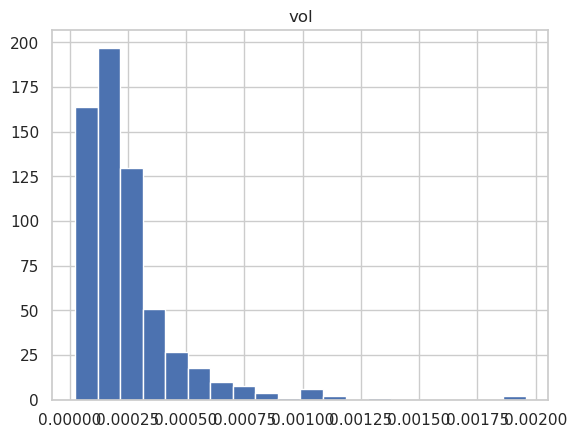

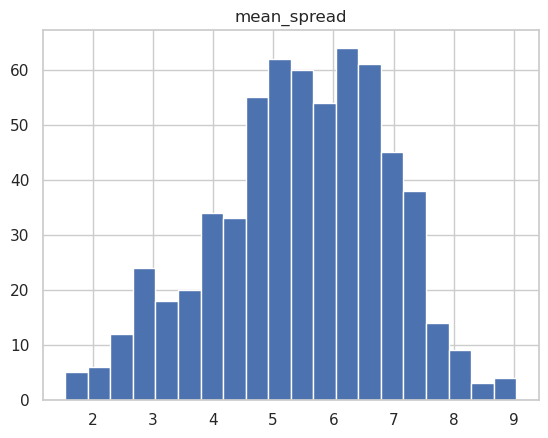

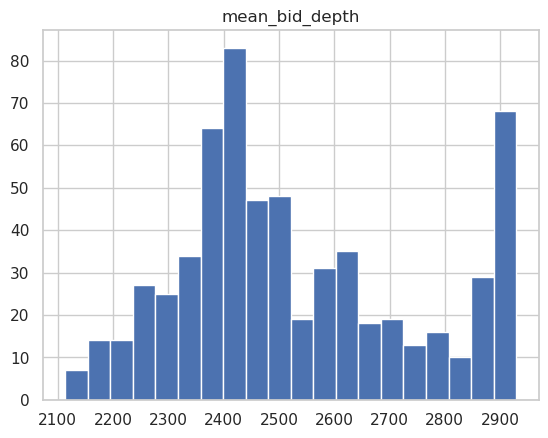

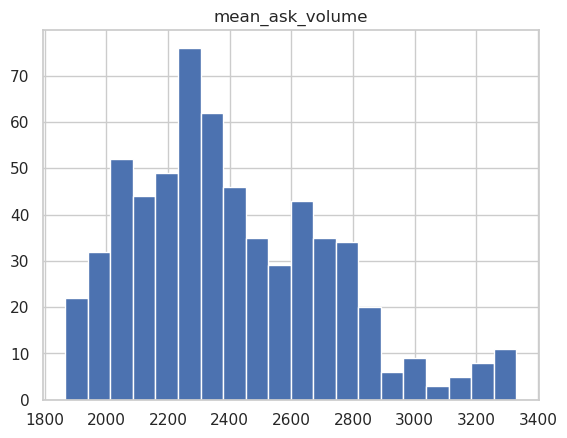

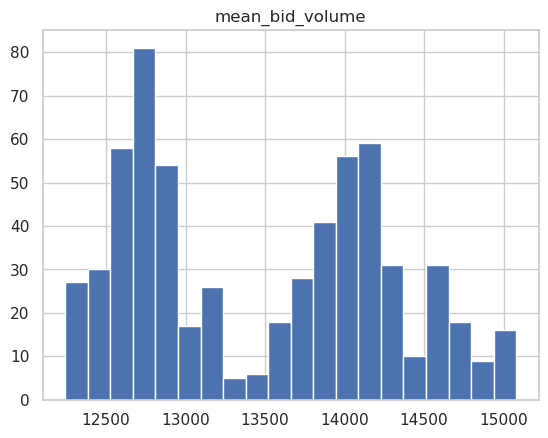

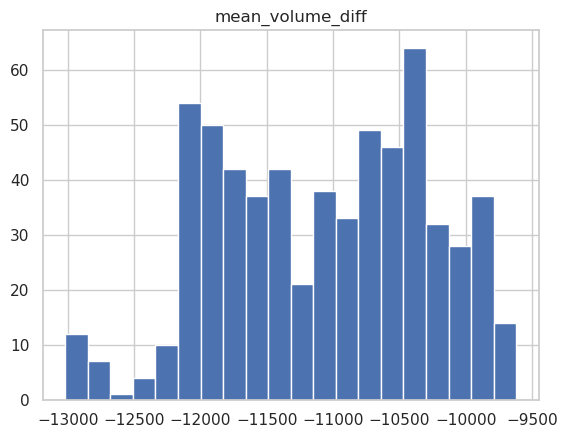

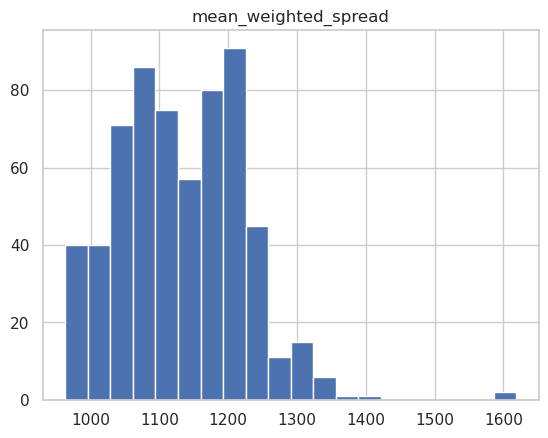

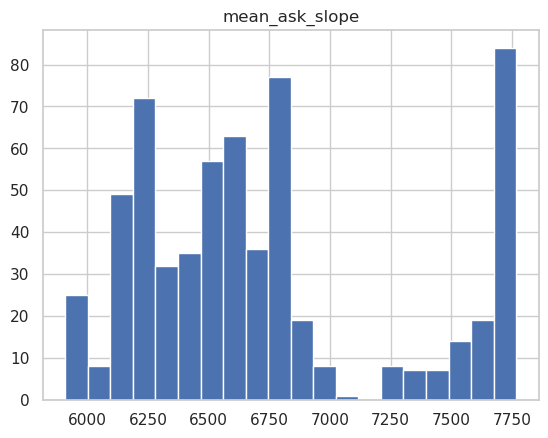

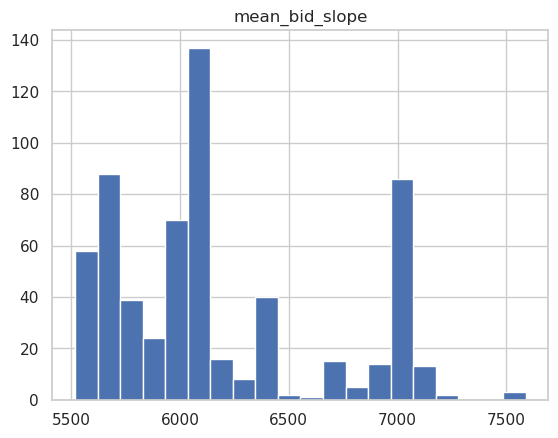

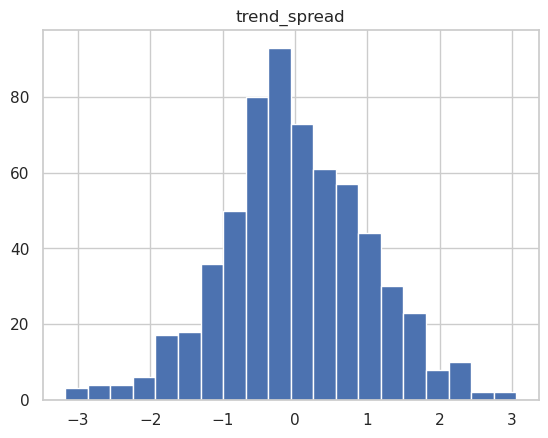

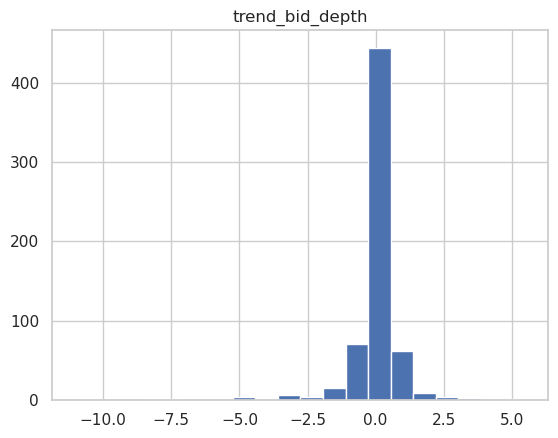

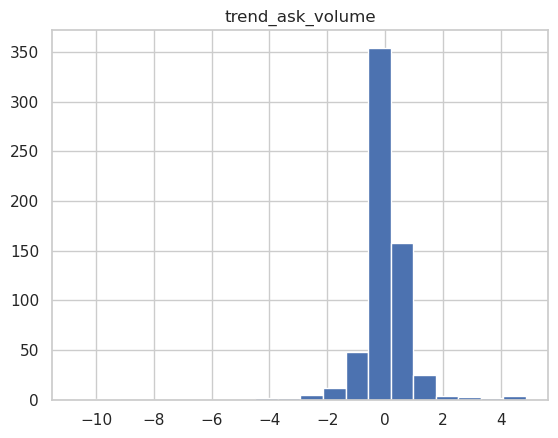

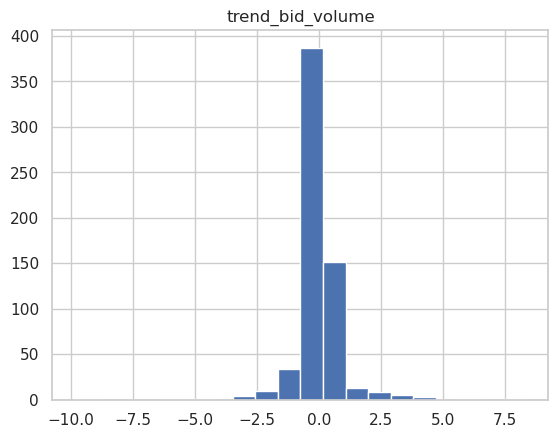

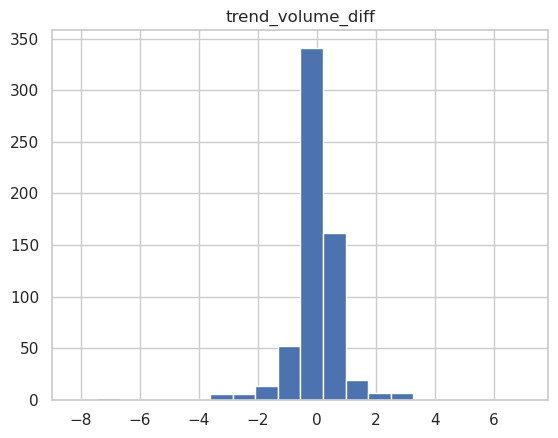

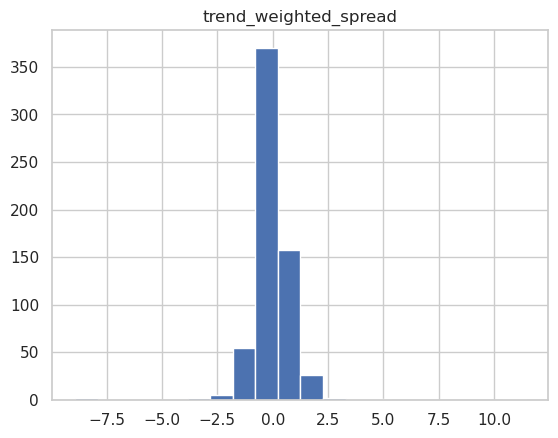

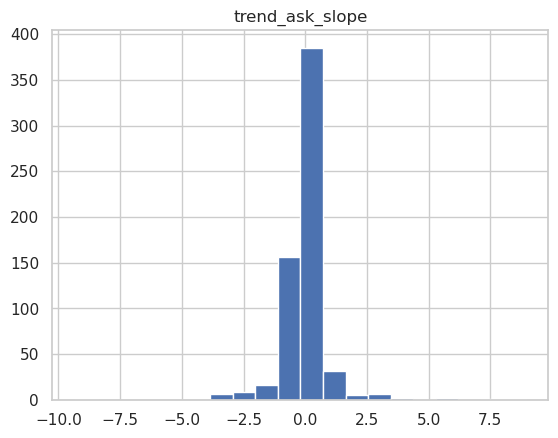

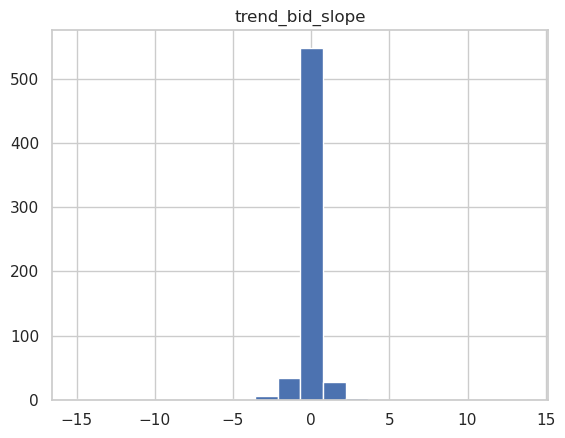

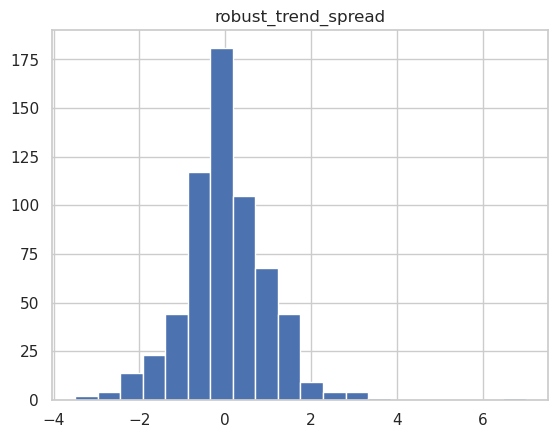

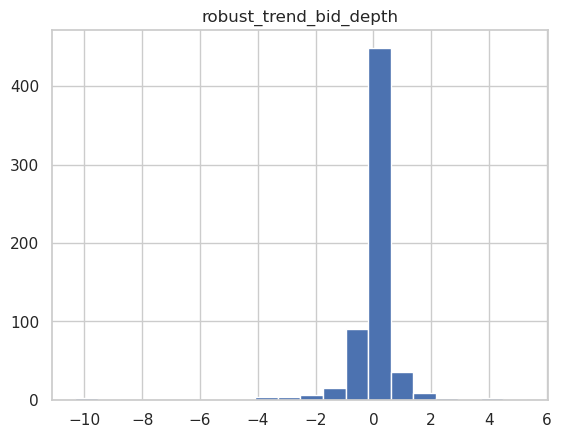

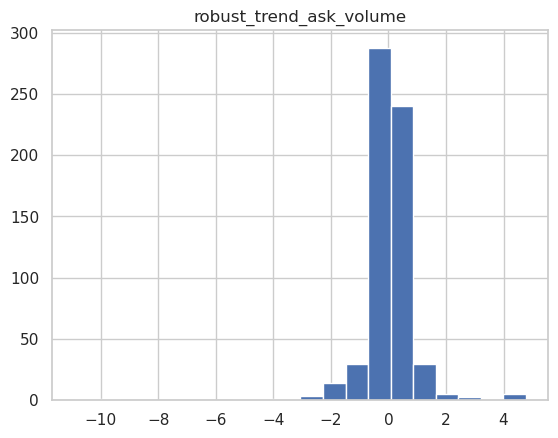

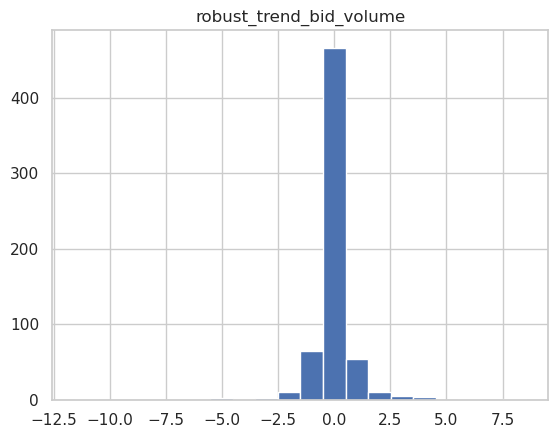

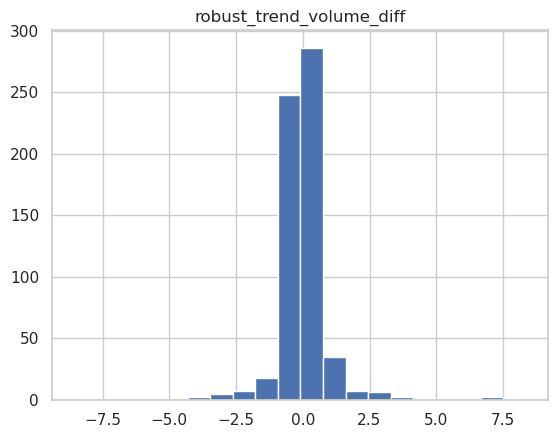

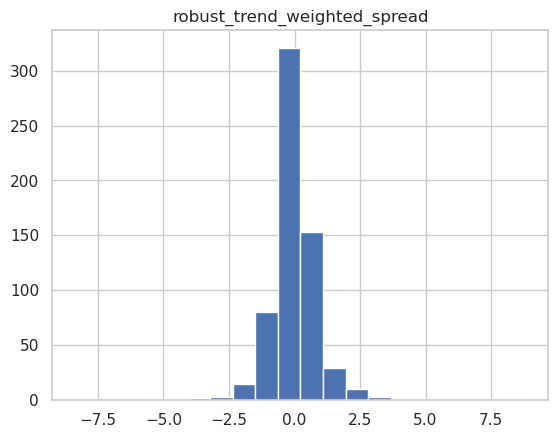

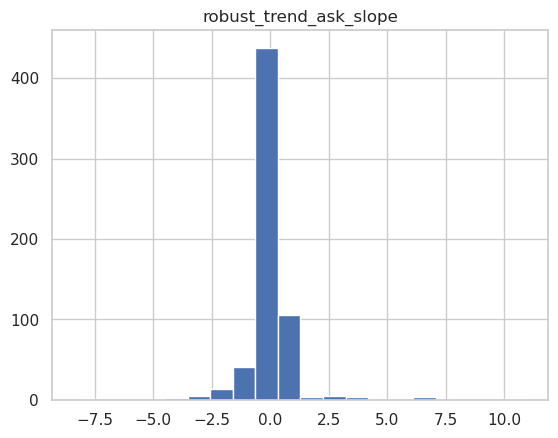

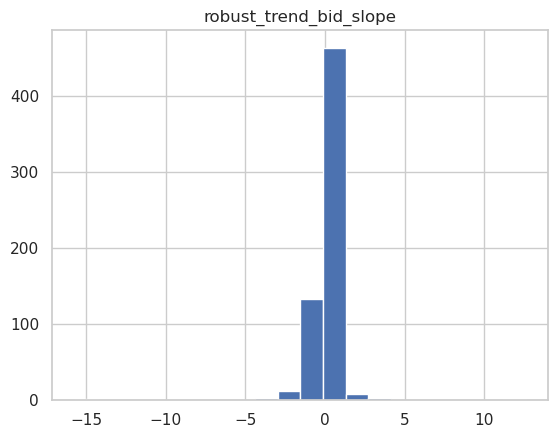

In [82]:
for col in training_data.columns:
    plt.hist(training_data[col], bins=20)
    plt.title(col)
    plt.show()

We should:
1. Winsorize trend and robust trend features to remove outliers
2. Transform volatility into log volatility
3. Standardize all variables

### Windsorization of trend and robust trend features

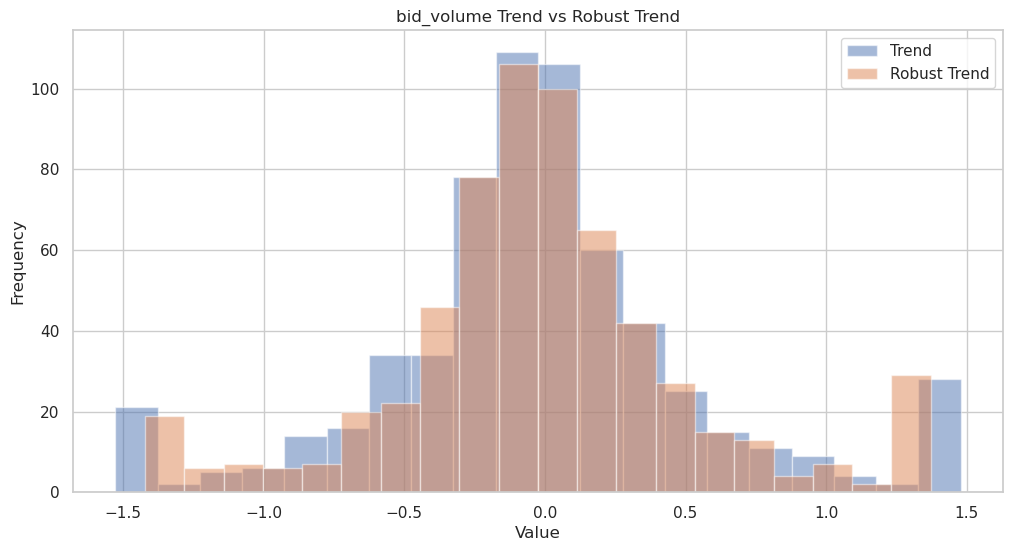

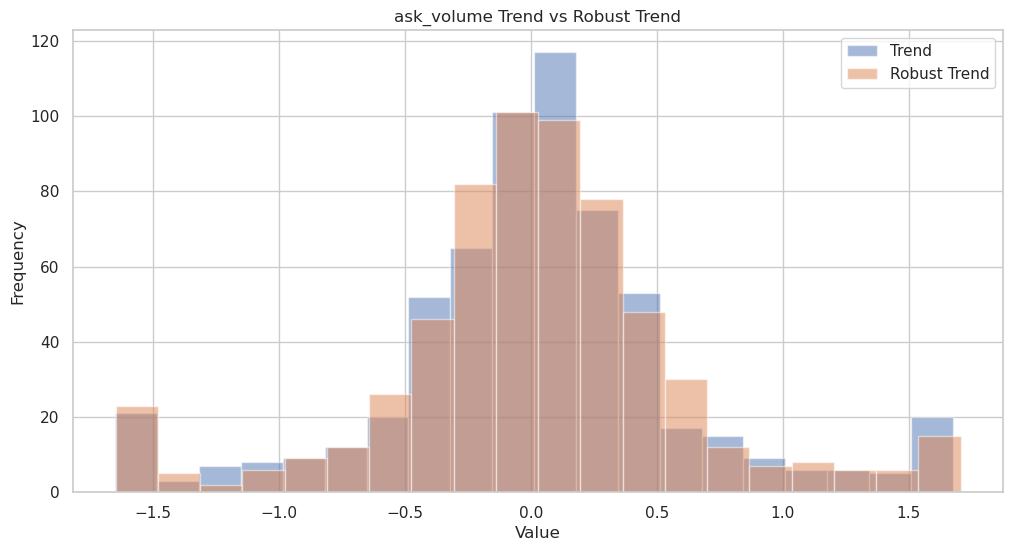

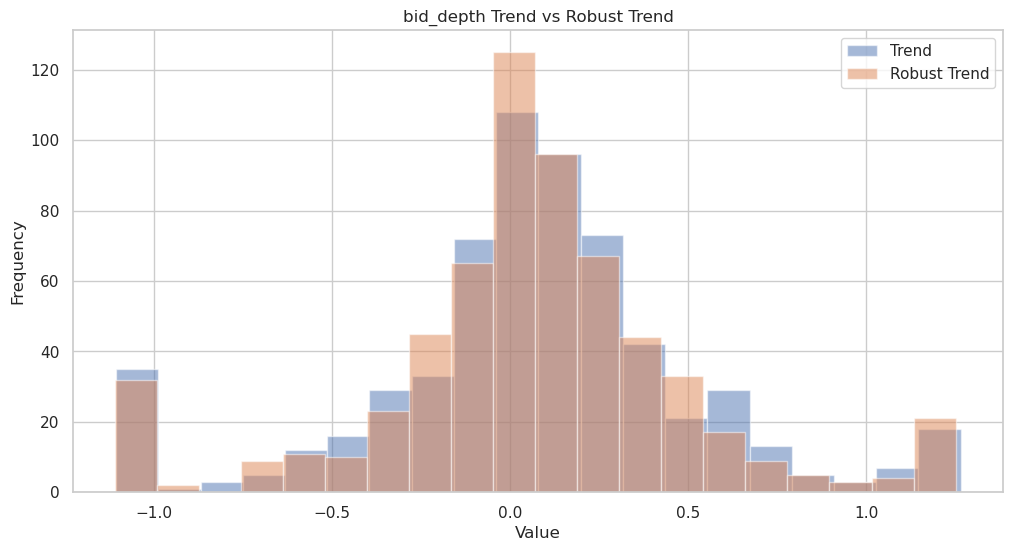

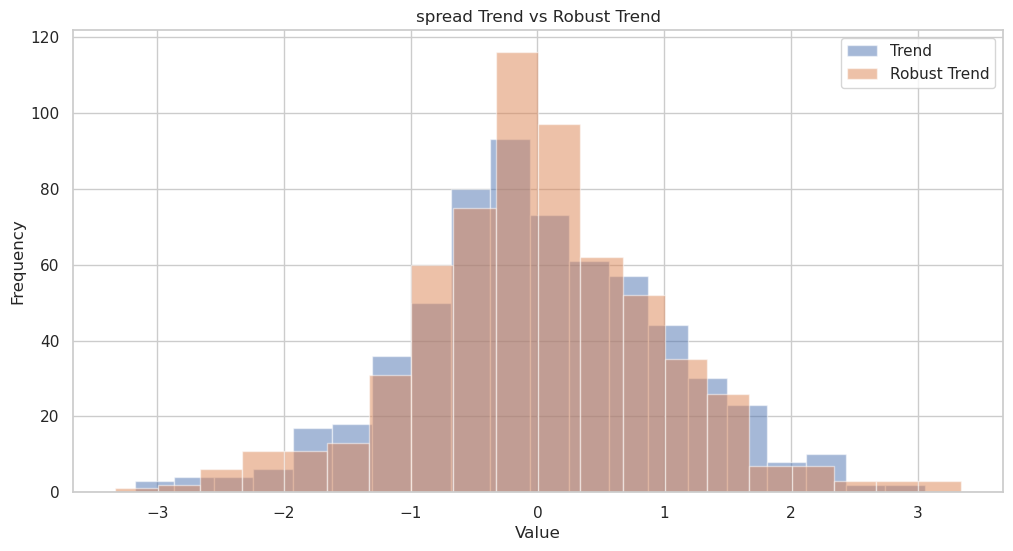

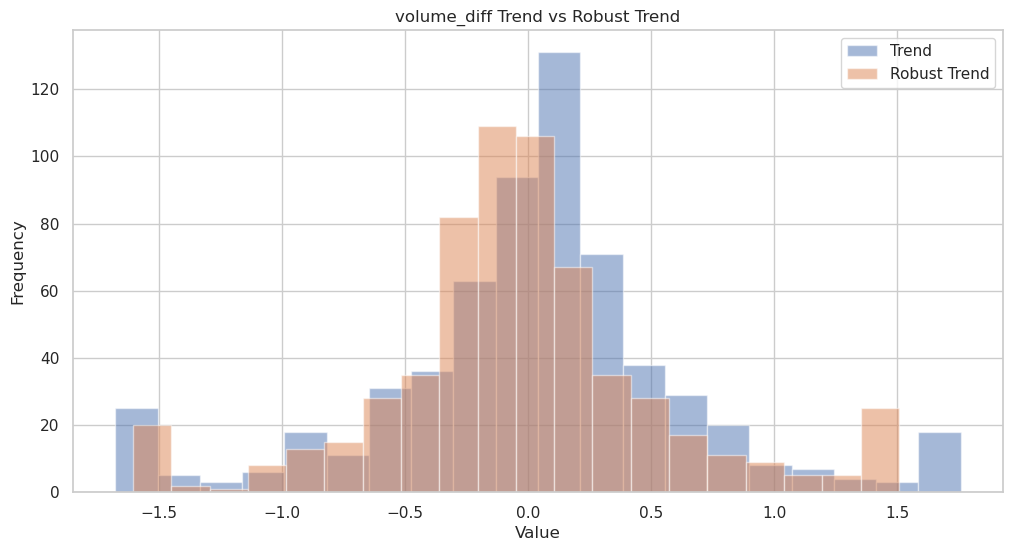

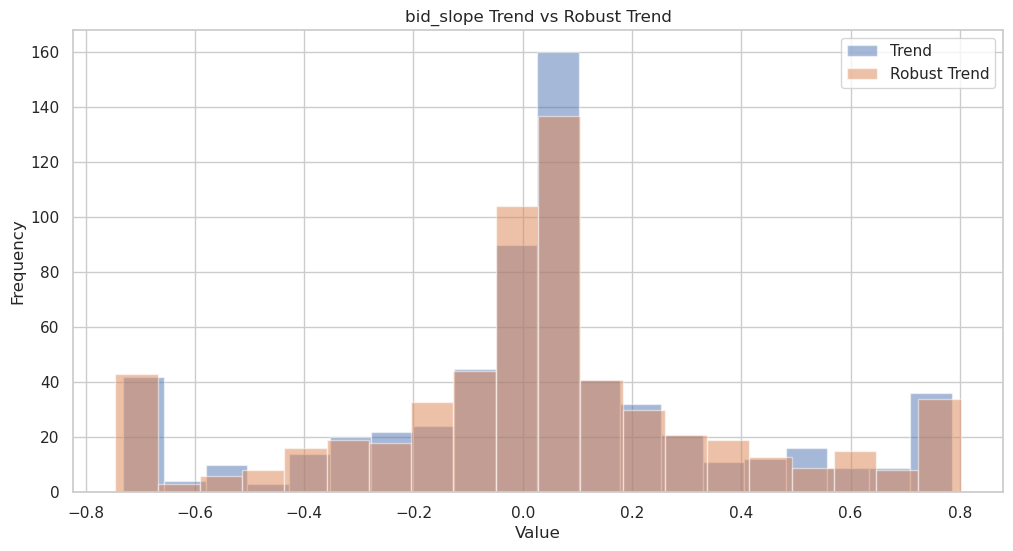

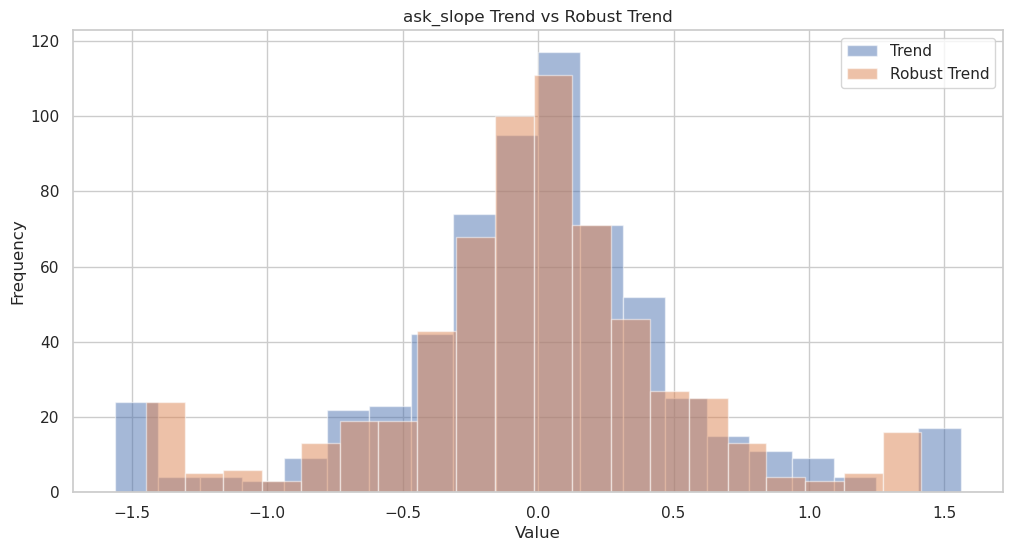

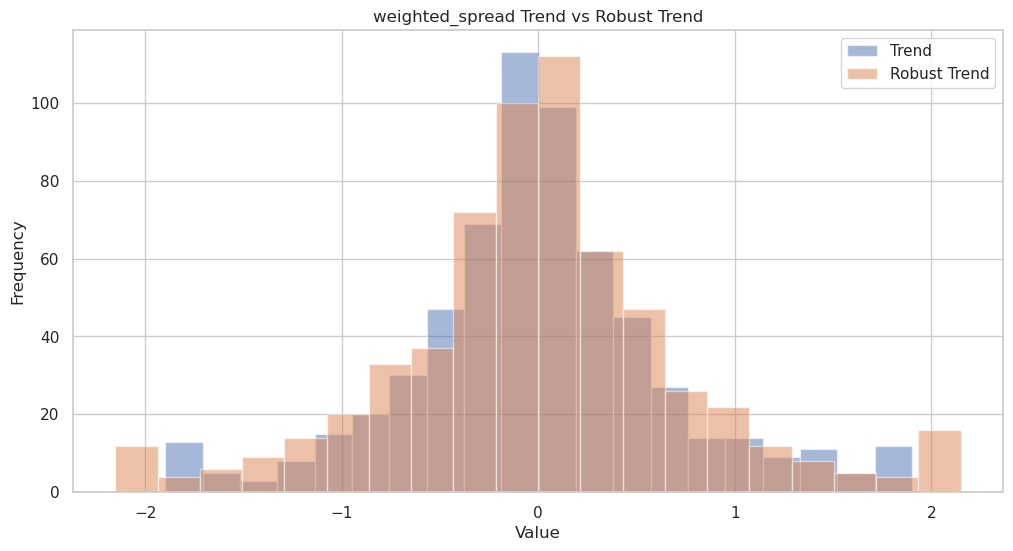

In [83]:
# winsorize trend variables

def winsorize_trend(df, col):
    """
    Winsorize the trend variables to remove outliers
    """
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 2.5 * iqr
    upper_bound = q3 + 2.5 * iqr

    df.loc[:,col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df.loc[:,col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

# for col in training_data.columns:
#     if "trend" in col:
#         training_data = winsorize_trend(training_data, col)
#         plt.hist(training_data[col], bins=20)
#         plt.title(col)
#         plt.show()

for col in feature_names:
    trend_windorized = winsorize_trend(training_data, f'trend_{col}')
    robust_trend_windorized = winsorize_trend(training_data, f'robust_trend_{col}')
    plt.figure(figsize=(12, 6))
    plt.hist(trend_windorized[f'trend_{col}'], bins=20, alpha=0.5, label='Trend')
    plt.hist(robust_trend_windorized[f'robust_trend_{col}'], bins=20, alpha=0.5, label='Robust Trend')
    plt.title(f"{col} Trend vs Robust Trend")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

There is no obvious difference between trend and robust trend variables, except maybe for the spread, where the scaling of the robust trend seems to be be to narrow (some outliers made std too large for the robust trend of the spread). 

Let's inspect the correlation between trend and robust trend features. 

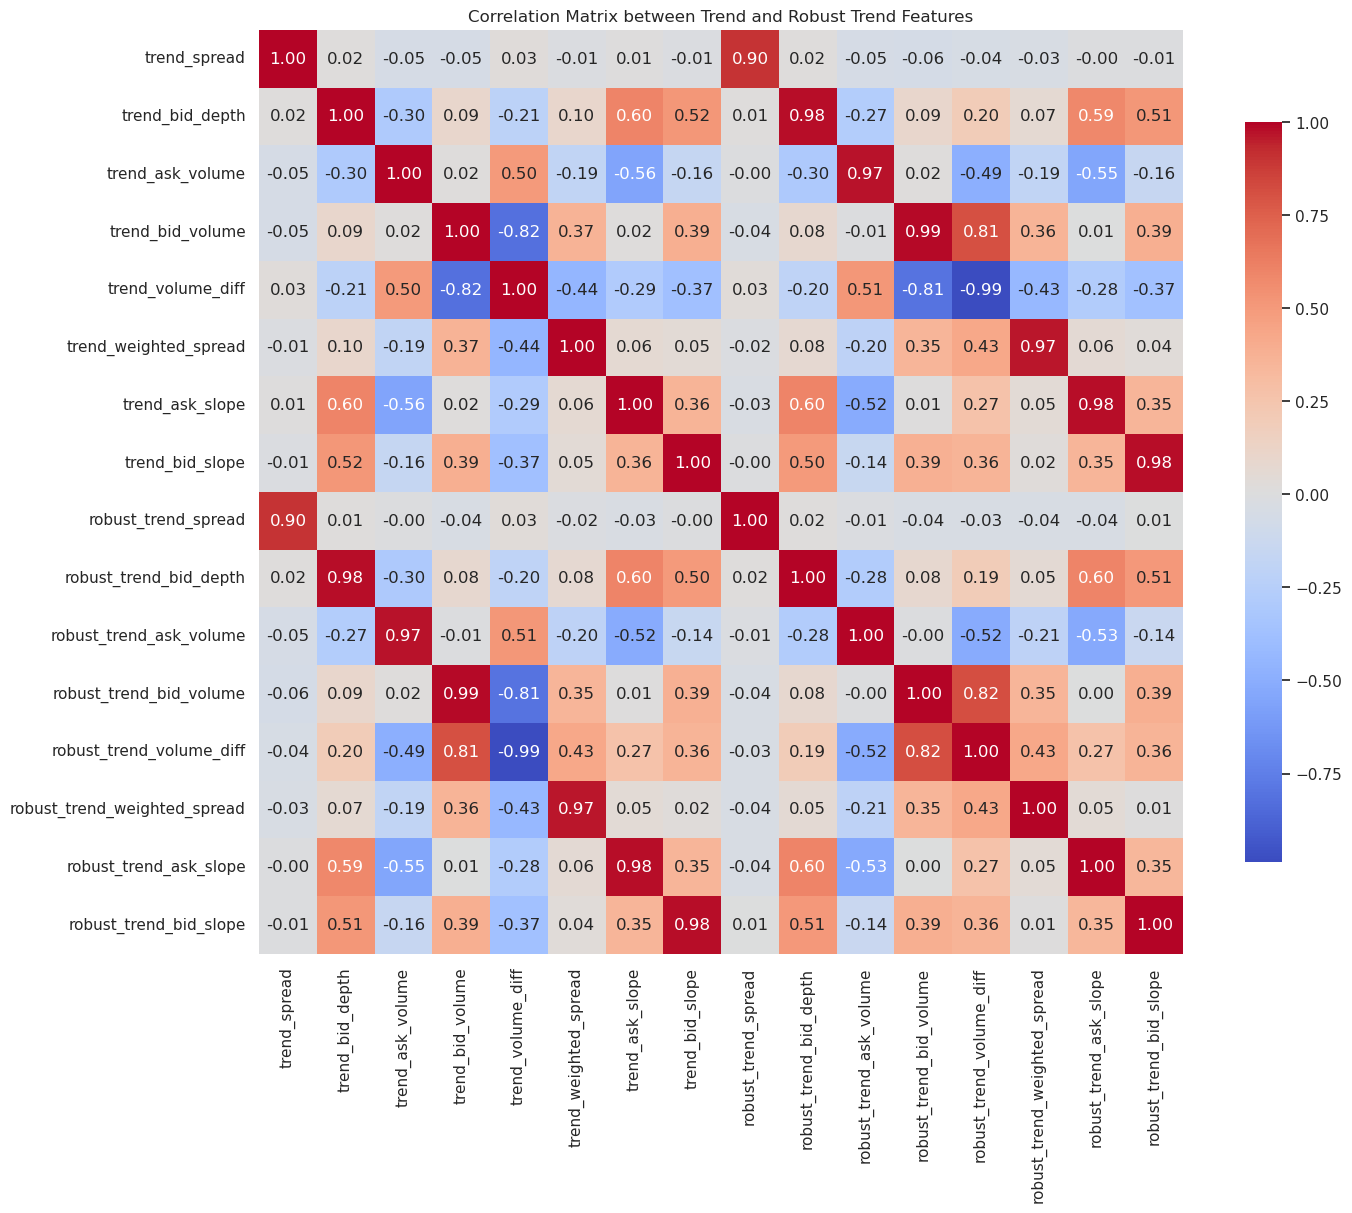

In [84]:
# correlation matrix
corr = training_data.loc[:,training_data.columns.str.startswith('trend_') | training_data.columns.str.startswith('robust_trend_')].corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix between Trend and Robust Trend Features")
plt.show()

### PCA on the trend features

In [85]:
trendvars=training_data.loc[:,training_data.columns.str.startswith('trend_')]

<Axes: xlabel='datetime'>

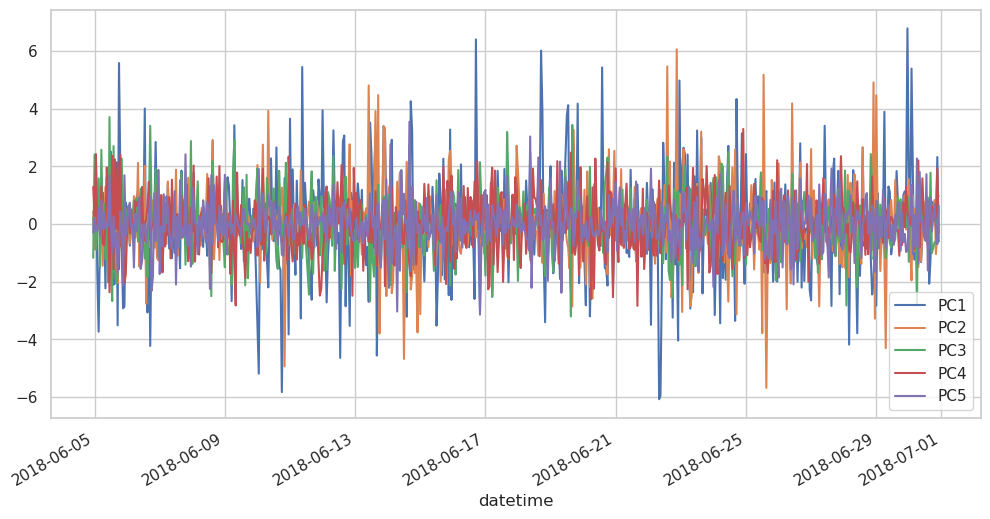

In [86]:
# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
ob_features_scaled = scaler.fit_transform(trendvars)
# Perform PCA
pca = PCA(n_components=5)
ob_features_pca = pca.fit_transform(ob_features_scaled)
# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=ob_features_pca, columns=["PC1", "PC2", "PC3", "PC4", "PC5"])
pca_df["datetime"] = ob_features["datetime"].to_numpy()
pca_df["datetime"] = pd.to_datetime(pca_df["datetime"])
pca_df = pca_df.sort_values("datetime")
pca_df.set_index("datetime", inplace=True)
pca_df.plot(figsize=(12, 6))
# explained variance

In [87]:
explained_variance = pca.explained_variance_ratio_.cumsum()
explained_variance

array([0.36075029, 0.56486823, 0.69979906, 0.82211813, 0.90891018])

In [88]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, index=trendvars.columns, columns=pca_df.columns)
#loadings_df = loadings_df.sort_values(by="PC1", ascending=False)
loadings_df

PC1       PC2       PC3       PC4       PC5
trend_spread          -0.014262 -0.135777  0.402701  0.905625  0.002388
trend_bid_depth        0.628144 -0.509399 -0.272579  0.079147 -0.346931
trend_ask_volume      -0.606223  0.341554 -0.551760  0.227540 -0.288961
trend_bid_volume       0.618712  0.684741 -0.222077  0.145958  0.147447
trend_volume_diff     -0.834933 -0.433188 -0.140444  0.018509 -0.263638
trend_weighted_spread  0.447088  0.461966  0.387120 -0.107645 -0.632211
trend_ask_slope        0.649295 -0.596978  0.085798 -0.119941 -0.003772
trend_bid_slope        0.653447 -0.121153 -0.560371  0.233059  0.025307

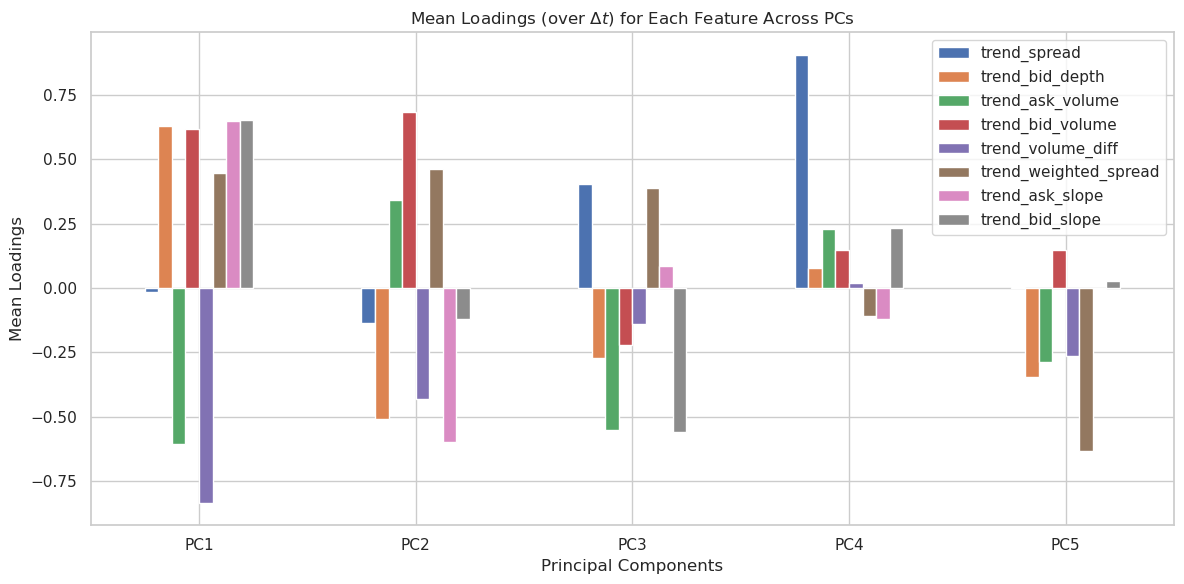

In [89]:
# plot mean loadings
mean_loadings_tr = loadings_df.T
mean_loadings_tr.plot(kind="bar", figsize=(12, 6))
plt.title(r"Mean Loadings (over $\Delta t$) for Each Feature Across PCs")
plt.xlabel("Principal Components")
plt.ylabel("Mean Loadings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

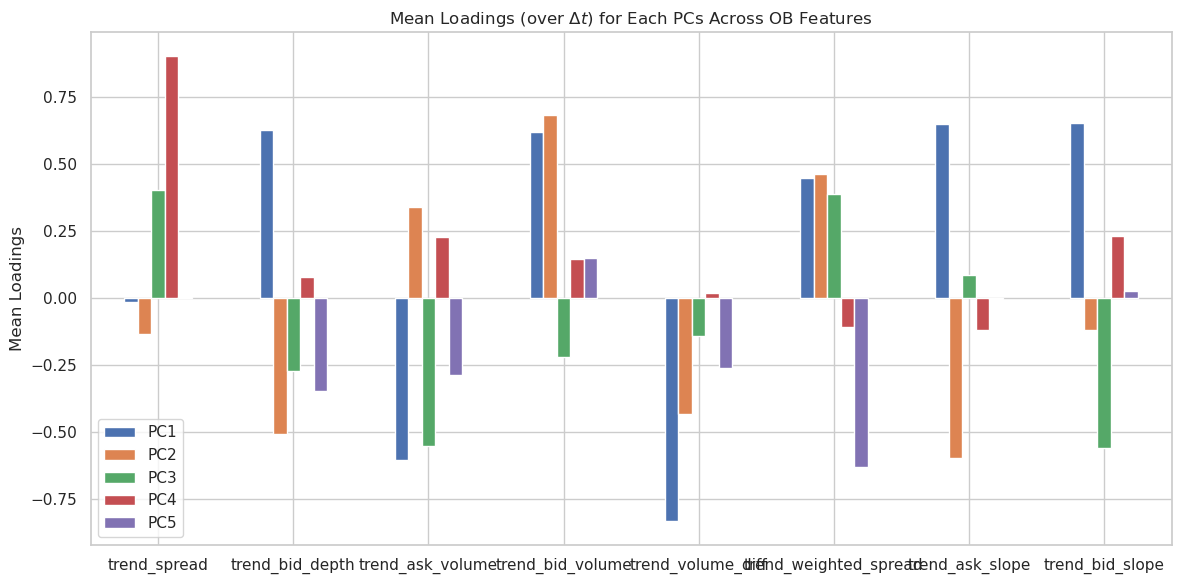

In [90]:
loadings_df.plot(kind="bar", figsize=(12, 6))
plt.title(r"Mean Loadings (over $\Delta t$) for Each PCs Across OB Features")
#plt.xlabel("Principal Components")
plt.ylabel("Mean Loadings")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Conclusion about trend and robust trend

Trend and robust trend features are highly correlated (w.r.t. Pearson, Kendall or Spearman coef. of corr.), and their distributions are very similar after winsorization. Thus, we will keep only the trend features, and drop the robust trend features.

Windsorization will be done for trend variables.

PCA on the level and another PCA for the trend features would reduce the total number of OB features from 16 to 10, at 90% of variance explained. This is not much, but we will try models with and without PCA in the model development notebooks.

Standardization, windsorization, and PCA, are all done inside individual models, in an online fashion.

# Make output templates

In [91]:
full_data = (
    pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
    .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
    .sort("datetime")
    ).to_pandas().set_index("datetime")
LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")

In [92]:
test_data = full_data.loc[LAST_TRAINING_DATE:]

In [93]:
test_data

vol       ret   ret_t-1   ret_t-2   ret_t-3  \
datetime                                                                
2018-07-03 23:00:00  0.000285  0.004757  0.000070  0.000310 -0.000913   
2018-07-04 00:00:00  0.000241 -0.008128 -0.000990  0.002352  0.001386   
2018-07-04 01:00:00  0.000240  0.000449  0.000963 -0.000935 -0.001475   
2018-07-04 02:00:00  0.000173  0.000458 -0.002634  0.000704 -0.000730   
2018-07-04 03:00:00  0.000177  0.001280 -0.001011  0.001256 -0.000115   
...                       ...       ...       ...       ...       ...   
2018-09-30 17:00:00  0.000025 -0.000451 -0.000860  0.002857  0.000204   
2018-09-30 18:00:00  0.000014  0.000298  0.000607 -0.000619 -0.000017   
2018-09-30 19:00:00  0.000024 -0.002138 -0.000023 -0.000018  0.001304   
2018-09-30 20:00:00  0.000089 -0.003682 -0.000012  0.000760 -0.000497   
2018-09-30 21:00:00  0.000034  0.000611 -0.003663 -0.000011  0.001097   

                      ret_t-4   ret_t-5   ret_t-6   ret_t-7   ret_t-8  ...  \
datetime                                                               ...   
2018-07-03 23:00:00 -0.000027 -0.002540 -0.001752 -0.008606 -0.002550  ...   
2018-07-04 00:00:00 -0.000216  0.000018  0.000199 -0.000717  0.001636  ...   
2018-07-04 01:00:00 -0.002879  0.001830 -0.002742  0.000978 -0.000227  ...   
2018-07-04 02:00:00 -0.001463  0.000829  0.003289  0.000322  0.000285  ...   
2018-07-04 03:00:00  0.000712 -0.000528 -0.000147  0.000252 -0.001782  ...   
...                       ...       ...       ...       ...       ...  ...   
2018-09-30 17:00:00 -0.000439  0.000296  0.000723 -0.000709  0.000164  ...   
2018-09-30 18:00:00 -0.000020 -0.000150 -0.000742 -0.000193  0.000521  ...   
2018-09-30 19:00:00  0.000129  0.000396 -0.000298 -0.000406  0.000384  ...   
2018-09-30 20:00:00 -0.000854 -0.000152  0.000149 -0.002735  0.000052  ...   
2018-09-30 21:00:00 -0.003005  0.000823 -0.005300  0.004849  0.002053  ...   

                     ask_depth_t-120  bid_depth_t-120  depth_diff_t-120  \
datetime                                                                  
2018-07-03 23:00:00           4000.0           2654.0            1346.0   
2018-07-04 00:00:00           4000.0           2672.0            1328.0   
2018-07-04 01:00:00           4000.0           2650.0            1350.0   
2018-07-04 02:00:00           4000.0           2625.0            1375.0   
2018-07-04 03:00:00           4000.0           2624.0            1376.0   
...                              ...              ...               ...   
2018-09-30 17:00:00           4000.0           2841.0            1159.0   
2018-09-30 18:00:00           4000.0           2840.0            1160.0   
2018-09-30 19:00:00           4000.0           2841.0            1159.0   
2018-09-30 20:00:00           4000.0           2845.0            1155.0   
2018-09-30 21:00:00           4000.0           2839.0            1161.0   

                     ask_volume_t-120  bid_volume_t-120  volume_diff_t-120  \
datetime                                                                     
2018-07-03 23:00:00       2205.873365      14970.231950      -12764.358585   
2018-07-04 00:00:00       2181.357432      14990.464470      -12809.107038   
2018-07-04 01:00:00       2204.039464      14937.132604      -12733.093141   
2018-07-04 02:00:00       2217.612444      14842.550268      -12624.937823   
2018-07-04 03:00:00       2158.504284      14871.097858      -12712.593574   
...                               ...               ...                ...   
2018-09-30 17:00:00       2627.367204      11909.731066       -9282.363863   
2018-09-30 18:00:00       2614.198169      11899.085884       -9284.887715   
2018-09-30 19:00:00       2597.208539      11936.342886       -9339.134347   
2018-09-30 20:00:00       2607.346074      11983.235011       -9375.888938   
2018-09-30 21:00:00       2643.073340      11848.354147       -9205.280807   

                     weighted_spread_t-120  ask_slope_t-120  bid_slope

In [94]:
test_data.index

DatetimeIndex(['2018-07-03 23:00:00', '2018-07-04 00:00:00',
               '2018-07-04 01:00:00', '2018-07-04 02:00:00',
               '2018-07-04 03:00:00', '2018-07-04 04:00:00',
               '2018-07-04 05:00:00', '2018-07-04 06:00:00',
               '2018-07-04 07:00:00', '2018-07-04 08:00:00',
               ...
               '2018-09-30 12:00:00', '2018-09-30 13:00:00',
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00'],
              dtype='datetime64[us]', name='datetime', length=1958, freq=None)

In [95]:
output_template = pd.DataFrame(index=test_data.index, columns=["retraining_flag", "model_name"])

In [96]:
output_template.retraining_flag = False

In [97]:
output_template

retraining_flag model_name
datetime                                       
2018-07-03 23:00:00            False        NaN
2018-07-04 00:00:00            False        NaN
2018-07-04 01:00:00            False        NaN
2018-07-04 02:00:00            False        NaN
2018-07-04 03:00:00            False        NaN
...                              ...        ...
2018-09-30 17:00:00            False        NaN
2018-09-30 18:00:00            False        NaN
2018-09-30 19:00:00            False        NaN
2018-09-30 20:00:00            False        NaN
2018-09-30 21:00:00            False        NaN

[1958 rows x 2 columns]

In [98]:
refit_dates = pd.date_range(start=output_template.index[0],
                 end=output_template.index[-1]+ pd.Timedelta(days=5), # to include the last week
                 freq='5D')
refit_dates

DatetimeIndex(['2018-07-03 23:00:00', '2018-07-08 23:00:00',
               '2018-07-13 23:00:00', '2018-07-18 23:00:00',
               '2018-07-23 23:00:00', '2018-07-28 23:00:00',
               '2018-08-02 23:00:00', '2018-08-07 23:00:00',
               '2018-08-12 23:00:00', '2018-08-17 23:00:00',
               '2018-08-22 23:00:00', '2018-08-27 23:00:00',
               '2018-09-01 23:00:00', '2018-09-06 23:00:00',
               '2018-09-11 23:00:00', '2018-09-16 23:00:00',
               '2018-09-21 23:00:00', '2018-09-26 23:00:00',
               '2018-10-01 23:00:00'],
              dtype='datetime64[ns]', freq='5D')

In [99]:
dates = iter(refit_dates)

In [100]:
refit_dates = list(refit_dates)

prev = refit_dates[0] - pd.Timedelta(days=7)
next = refit_dates[0]
prev_writing = refit_dates[0]
for t in output_template.index:
    if prev < t and t >= next:
        prev = next
        next = refit_dates[refit_dates.index(next) + 1]
        output_template.loc[t, "retraining_flag"] = True
        print(f"Size of the window: {pd.Timedelta(t - prev_writing)}")
        prev_writing = t

Size of the window: 0 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 6 days 00:00:00
Size of the window: 4 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 7 days 00:00:00
Size of the window: 3 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00
Size of the window: 5 days 00:00:00


In [101]:
output_template.loc[output_template.loc[:, "retraining_flag"] == True].head(20)

retraining_flag model_name
datetime                                       
2018-07-03 23:00:00             True        NaN
2018-07-08 23:00:00             True        NaN
2018-07-13 23:00:00             True        NaN
2018-07-18 23:00:00             True        NaN
2018-07-23 23:00:00             True        NaN
2018-07-28 23:00:00             True        NaN
2018-08-03 23:00:00             True        NaN
2018-08-07 23:00:00             True        NaN
2018-08-12 23:00:00             True        NaN
2018-08-17 23:00:00             True        NaN
2018-08-22 23:00:00             True        NaN
2018-08-27 23:00:00             True        NaN
2018-09-03 23:00:00             True        NaN
2018-09-06 23:00:00             True        NaN
2018-09-11 23:00:00             True        NaN
2018-09-16 23:00:00             True        NaN
2018-09-21 23:00:00             True        NaN
2018-09-26 23:00:00             True        NaN

In [102]:
# save the output template
output_template.to_csv(data_path / "btc" / "output_template.csv", index=True)

In [103]:
loaded = pd.read_csv(data_path / "btc" / "output_template.csv", index_col=0)

In [104]:
output_template.index

DatetimeIndex(['2018-07-03 23:00:00', '2018-07-04 00:00:00',
               '2018-07-04 01:00:00', '2018-07-04 02:00:00',
               '2018-07-04 03:00:00', '2018-07-04 04:00:00',
               '2018-07-04 05:00:00', '2018-07-04 06:00:00',
               '2018-07-04 07:00:00', '2018-07-04 08:00:00',
               ...
               '2018-09-30 12:00:00', '2018-09-30 13:00:00',
               '2018-09-30 14:00:00', '2018-09-30 15:00:00',
               '2018-09-30 16:00:00', '2018-09-30 17:00:00',
               '2018-09-30 18:00:00', '2018-09-30 19:00:00',
               '2018-09-30 20:00:00', '2018-09-30 21:00:00'],
              dtype='datetime64[us]', name='datetime', length=1958, freq=None)